In [1]:
import sys
import os
import torch
from sampler import *
from utils import get_predictions_1
import gpytorch
os.chdir("/home/kreffert/Probabilistic_LTSF/ProbTS")
from run import ProbTSCli
from probts.data import ProbTSBatchData
from probts.data import DataManager, ProbTSDataModule
from probts.utils import find_best_epoch
from probts.model.forecast_module import ProbTSForecastModule
from notebook.utils import plot_time_series, get_predictions, plot_qq_coverage

/home/kreffert/miniconda3/envs/probts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET = 'etth1'
MODEL = 'patchtst_prob'
args={'config': f'config/ltsf/{DATASET}/{MODEL}.yaml', 
        'seed_everything':0,
       'data.data_manager.init_args.path': './datasets',
       'trainer.default_root_dir': './log_dir',
       'data.data_manager.init_args.dataset':f'{DATASET}',
       'data.data_manager.init_args.split_val': True,
       'trainer.max_epochs':50,
       'data.data_manager.init_args.context_length':96,
       'data.data_manager.init_args.prediction_length':96,
       'model.forecaster.no_training':True,
     'model.load_from_ckpt': "/home/kreffert/Probabilistic_LTSF/ProbTS/log_dir/etth1_PatchTST_prob_CTX96_PRED96_seed0/ckpt/",}

sys.argv = ['run.py']

sys.argv += [item for k, v in args.items() for item in (f'--{k}', str(v))]

cli = ProbTSCli(
        datamodule_class=ProbTSDataModule,
        model_class=ProbTSForecastModule,
        save_config_kwargs={"overwrite": True},
        run=False
    )
cli.init_exp(logging=False)
cli.set_test_mode()
cli.trainer.test(model=cli.model, datamodule=cli.datamodule)

[rank: 0] Seed set to 0
INFO:root:first/last timestamp found: 2016-07-01 00:00/2017-06-25 23:00
INFO:root:group training time series to datasets
INFO:root:first/last timestamp found: 2016-07-01 00:00/2017-10-23 23:00
INFO:root:group training time series to datasets
INFO:root:first/last timestamp found: 2016-07-01 00:00/2018-02-20 23:00
INFO:root:group training time series to datasets
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading Long-term Dataset: etth1
val  pred_len: 96 : num_test_windows: 29
test  pred_len: 96 : num_test_windows: 29
Test context length: [96], prediction length: [96]
Validation context length: [96], prediction length: [96]
Training context length: [96], prediction lengths: [96]
Test rolling length: 96
Variable-specific normalization: True
sampling_weight_scheme: none


INFO:run:Loading pre-trained checkpoint from /home/kreffert/Probabilistic_LTSF/ProbTS/log_dir/etth1_PatchTST_prob_CTX96_PRED96_seed0/ckpt/epoch=49-val_CRPS=0.283364.ckpt


find best ckpt  epoch=49-val_CRPS=0.283364.ckpt
sampling_weight_scheme: none


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |                                                                                          | 1/? [00:08<00:00,  0.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.30771809816360474    │
│     96_test_CRPS-Sum      │    0.22206513583660126    │
│       96_test_MASE        │     1.304531455039978     │
│        96_test_MSE        │    11.077550888061523     │
│      96_test_MSE-Sum      │    124.68760681152344     │
│        96_test_ND         │    0.4005759656429291     │
│      96_test_ND-Sum       │    0.2887555658817291     │
│       96_test_NRMSE       │    0.6984689235687256     │
│     96_test_NRMSE-Sum     │    0.38561052083969116    │
│    96_test_weighted_ND    │    0.4005759656429291     │
│  96_test_weighted_ND-Sum  │    0.2887555658817291     │
└───────────────────────────┴───────────────────────────┘

[{'96_test_ND': 0.4005759656429291,
  '96_test_ND-Sum': 0.2887555658817291,
  '96_test_weighted_ND': 0.4005759656429291,
  '96_test_weighted_ND-Sum': 0.2887555658817291,
  '96_test_CRPS': 0.30771809816360474,
  '96_test_CRPS-Sum': 0.22206513583660126,
  '96_test_NRMSE': 0.6984689235687256,
  '96_test_NRMSE-Sum': 0.38561052083969116,
  '96_test_MSE': 11.077550888061523,
  '96_test_MSE-Sum': 124.68760681152344,
  '96_test_MASE': 1.304531455039978}]

In [3]:
test_dataloader = cli.datamodule.test_dataloader()
model = cli.model
model.eval()  # Ensure model is in eval mode
device = 'cpu'
model.to(device)  # Move to appropriate device
mean_predictions = []
std_predictions = []
past_actuals = []
future_actuals = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        batch = {key: val.to(device) for key, val in batch.items()}  # Move batch to device
        # Extract past actual values
        past_values = batch["past_target_cdf"].cpu()  # Shape: (batch_size, past_seq_len)
        print(past_values.shape)
        past_actuals.append(past_values)

        # Extract future actual values
        future_values = batch["future_target_cdf"].cpu()  # Shape: (batch_size, future_seq_len)
        future_actuals.append(future_values)
        print(future_values.shape)

        # Store predictions
        batch_data = ProbTSBatchData(batch, device)
        forecast = model.forecaster.forecast(batch_data, None)#predict_step(batch, batch_idx)
        mean_forecast = forecast[0]
        std_forecast = forecast[1]
        print(mean_forecast.shape)
        print(std_forecast.shape)
        #mean_forecast = mean_forecast.squeeze(1)
        mean_predictions.append(mean_forecast.cpu())
        std_predictions.append(std_forecast.cpu())

# Convert to numpy if needed
mean_predictions = torch.cat(mean_predictions, dim=0).numpy()
std_predictions = torch.cat(std_predictions, dim=0).numpy()
past_actuals = torch.cat(past_actuals, dim=0).numpy()
future_actuals = torch.cat(future_actuals, dim=0).numpy()

torch.Size([29, 264, 7])
torch.Size([29, 96, 7])
torch.Size([29, 96, 7])
torch.Size([29, 96, 7])


In [ ]:
plot_time_series(past_actuals, future_actuals, predictions, windows=[0, 1, 15, 16], series=[0, 1, 2, 3, 4, 5, 6], ci=ci)
predictions, past_actuals, future_actuals = get_predictions(cli)
ci = [5, 95]

In [ ]:
plot_qq_coverage(future_actuals, predictions, windows=[0, 1, 15, 16], series=[0, 1, 2, 3, 4, 5, 6], quantile_levels=quantile_levels)#, version='upper')
quantile_levels = [0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99]

# BoTorch

In [5]:
import torch
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import seaborn as sns

class SeriesSampler_1:
    def __init__(self, gp_model, base_model, train_loader, test_loader, num_samples=1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.gp_model = gp_model
        self.base_model = base_model  # Added reference to base_model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_samples = num_samples

        self.gp_model = gp_model
        # Check model type
        if "ProbTSForecastModule" in str(type(base_model)):
            self.model_type = "probts"
            from probts.data import ProbTSBatchData
            self.ProbTSBatchData = ProbTSBatchData  # Store for later use
        else:
            self.model_type = "basicts"

    def run(self):
        # 1. Fit the GP
        self.fit_gp()

        # 2. Make the predictions
        mean_predictions, std_predictions = self.get_predictions_base_model()
        mean_pred = mean_predictions[0, :, 0]
        std_pred = std_predictions[0, :, 0]

        # 3. Get test data
        #test_x, _ = self.get_first_batch(self.test_loader)
        
        # 4. define new posterior
        new_posterior = self.init_distribution(mean_pred, std_pred)

        return self.sample(new_posterior)

    def get_batch(self, data_loader, first=True):
        if first:
            # select the first batch
            _iter = iter(data_loader) 
            batch = next(_iter)
        else:
            # select the last batch
            last_batch = None
            for batch in data_loader:
                last_batch = batch
            batch = last_batch
        
        past_target = batch['past_target_cdf'].to(self.device)
        future_target = batch['future_target_cdf'].to(self.device)
        targets = torch.cat([past_target, future_target], dim=1)  # batch_size, horizon, num_series = (32, 360, 7)
    
        num_series = 0
        targets = targets[0, :, num_series]  # only select first batch/window at first (360, num_series)
        horizon_length = targets.shape[0]
    
        x = torch.arange(horizon_length).to(self.device, dtype=torch.float32).unsqueeze(-1)  # [360, 1]
        y = targets.to(self.device, dtype=torch.float32).unsqueeze(-1)  # [360, num_series, 1]
        return x, y

    def fit_gp(self):
        if self.model_type == 'probts':
            # use the first batch to train
            x, y = self.get_batch(self.train_loader, first=False)

            self.gp_model = self.gp_model(train_X=x, train_Y=y)
            
            # Register noise constraint
            self.gp_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
            
            mll = ExactMarginalLogLikelihood(likelihood=self.gp_model.likelihood, model=self.gp_model)
            # Set mll and all submodules to the specified dtype and device
            mll = mll.to(x.device)
        
            optimizer = SGD([{"params": self.gp_model.parameters()}], lr=0.025)
            NUM_EPOCHS = 1500
        
            self.gp_model.train()
        
            for epoch in range(NUM_EPOCHS):
                optimizer.zero_grad()
                output = self.gp_model(x)
                loss = -mll(output, self.gp_model.train_targets)
                loss.backward()
                if (epoch + 1) % 100 == 0:
                    print(
                        f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
                        f"lengthscale: {self.gp_model.covar_module.lengthscale.item():>4.3f} "
                        f"noise: {self.gp_model.likelihood.noise.item():>4.3f}"
                    )
                optimizer.step()
        else:
            raise NotImplementedError(f"Model type {self.model_type} not implemented")

    def get_predictions_base_model(self):
        if self.model_type == "probts":
            self.base_model.eval()
            # need to transfer this here for some reason
            self.base_model.to('cpu')
            mean_predictions, std_predictions = [], []
            
            with torch.no_grad():
                for batch_idx, batch in enumerate(self.test_loader):
                    batch_data = self.ProbTSBatchData(batch, self.device)
                    
                    # assumes forecaster with gaussian distribution
                    mean_forecast, std_forecast = self.base_model.forecaster.forecast(batch_data, num_samples=None)
                    mean_forecast = mean_forecast.squeeze(1).to(self.device)
                    std_forecast = std_forecast.squeeze(1).to(self.device)
                    mean_predictions.append(mean_forecast)
                    std_predictions.append(std_forecast)
                    
            mean_predictions = torch.cat(mean_predictions, dim=0)
            std_predictions = torch.cat(std_predictions, dim=0)
            return mean_predictions, std_predictions
        else:
            raise NotImplementedError(f"Model type {self.model_type} not implemented")

    def init_distribution(self, mean_pred, std_pred):
        x, y = self.get_batch(self.test_loader, first=True)
        
        self.gp_model.eval()  # Ensure model is in evaluation mode
        
        # Filter x to match the length of mean_pred
        x_filter = x[-len(mean_pred):]
        
        # 1. Compute the kernel covariance matrix for the filtered test points
        kernel_matrix = self.gp_model.covar_module(x_filter).evaluate()
        
        # 2. Adjust the covariance matrix using the standard deviation predictions
        updated_cov = kernel_matrix + torch.diag(std_pred**2)  # Convert std to variance and create diagonal covariance
        
        # 3. Construct the updated Multivariate Normal distribution
        new_posterior = MultivariateNormal(mean_pred, updated_cov)
        return new_posterior

    def sample(self, distribution):
        # Sample self.num_samples realization(s) from the adjusted GP
        new_sample = distribution.rsample(torch.Size([self.num_samples]))  # Shape: (num_samples, test_x.size(0))
        return new_sample

    def visualize_corr(self):
        # Get test data
        test_x, _ = self.get_batch(self.test_loader, first=True)
        
        # Compute kernel matrix
        kernel_matrix = self.gp_model.covar_module(test_x).evaluate()
        
        # Visualize correlation
        plt.figure(figsize=(8, 6))
        sns.heatmap(kernel_matrix.detach().to('cpu'), cmap="coolwarm", square=True, cbar=True)
        plt.title("Kernel Matrix Correlation")
        plt.show()



base_model = cli.model
train_loader = cli.datamodule.train_dataloader()
test_loader = cli.datamodule.test_dataloader()
from botorch.models import SingleTaskGP
gp_model = SingleTaskGP
sampl = SeriesSampler_1(gp_model, base_model, train_loader, test_loader, num_samples=1)
sampl.run()
sampl.visualize_corr()

Exception in thread Thread-9 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)

KeyboardInterrupt: 

In [ ]:
base_model = cli.model
train_loader = cli.datamodule.train_dataloader()
test_loader = cli.datamodule.test_dataloader()
from botorch.models import SingleTaskGP
gp_model = SingleTaskGP
#model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
sampl = SeriesSampler_1(gp_model, base_model, train_loader, test_loader, num_samples=1)

In [ ]:
sampl.run()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def get_data(data_loader):
    _iter = iter(data_loader) 
    first_batch = next(_iter)
    past_target = first_batch['past_target_cdf'].to(device)
    future_target = first_batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # batch_size, horizon, num_series = (32, 360, 7)

    num_series = 0
    targets = targets[0, :, num_series] #only select first batch/window at first (360, num_series)
    horizon_length = targets.shape[0]

    x = torch.arange(horizon_length).to(device) # [360]
    y = targets.to(device)  # [360, num_series]
    return x, y

train_dataloader = cli.datamodule.train_dataloader()
test_dataloader = cli.datamodule.test_dataloader()
train_x, train_y = get_data(train_dataloader)
test_x, test_y = get_data(test_dataloader)

mean_predictions, std_predictions = get_predictions_1(cli)[:2]
mean_pred = mean_predictions[0, :, 0]
std_pred = std_predictions[0, :, 0]

Using device: cuda
torch.Size([29, 264, 7])
torch.Size([29, 96, 7])
torch.Size([29, 96, 7])
Epoch 100/1500 - Loss: 1.490 lengthscale: 0.205 noise: 0.617
Epoch 200/1500 - Loss: 1.480 lengthscale: 0.206 noise: 0.549
Epoch 300/1500 - Loss: 1.473 lengthscale: 0.207 noise: 0.493
Epoch 400/1500 - Loss: 1.466 lengthscale: 0.208 noise: 0.446
Epoch 500/1500 - Loss: 1.461 lengthscale: 0.209 noise: 0.406
Epoch 600/1500 - Loss: 1.457 lengthscale: 0.210 noise: 0.372
Epoch 700/1500 - Loss: 1.453 lengthscale: 0.211 noise: 0.343
Epoch 800/1500 - Loss: 1.450 lengthscale: 0.213 noise: 0.318
Epoch 900/1500 - Loss: 1.447 lengthscale: 0.215 noise: 0.296
Epoch 1000/1500 - Loss: 1.445 lengthscale: 0.217 noise: 0.277
Epoch 1100/1500 - Loss: 1.443 lengthscale: 0.221 noise: 0.260
Epoch 1200/1500 - Loss: 1.441 lengthscale: 0.225 noise: 0.245
Epoch 1300/1500 - Loss: 1.439 lengthscale: 0.233 noise: 0.232
Epoch 1400/1500 - Loss: 1.438 lengthscale: 0.250 noise: 0.219
Epoch 1500/1500 - Loss: 1.326 lengthscale: 0.562 

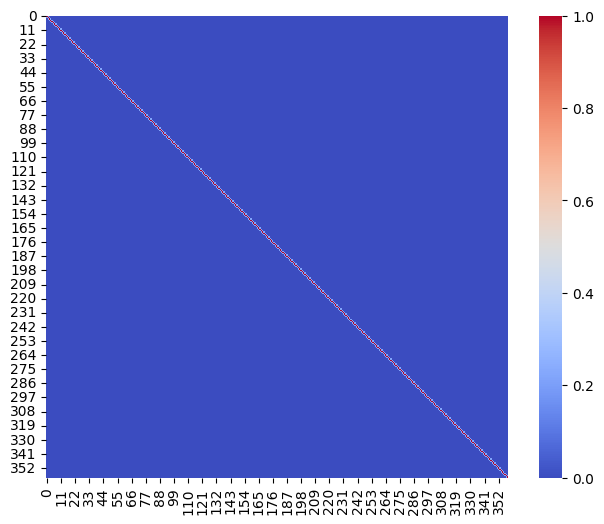

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def get_data(data_loader):
    _iter = iter(data_loader) 
    first_batch = next(_iter)
    past_target = first_batch['past_target_cdf'].to(device)
    future_target = first_batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # batch_size, horizon, num_series = (32, 360, 7)

    num_series = 0
    targets = targets[0, :, num_series] #only select first batch/window at first (360, num_series)
    horizon_length = targets.shape[0]

    x = torch.arange(horizon_length).to(device) # [360]
    y = targets.to(device)  # [360, num_series]
    return x, y

train_dataloader = cli.datamodule.train_dataloader()
test_dataloader = cli.datamodule.test_dataloader()
train_x, train_y = get_data(train_dataloader)
test_x, test_y = get_data(test_dataloader)

mean_predictions, std_predictions = get_predictions_1(cli)[:2]
mean_pred = mean_predictions[0, :, 0]
std_pred = std_predictions[0, :, 0]
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan

train_x = train_x.to(dtype=torch.float32).unsqueeze(-1)
train_y = train_y.to(dtype=torch.float32).unsqueeze(-1)
model = SingleTaskGP(train_X=train_x, train_Y=train_y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_x)

from torch.optim import SGD

optimizer = SGD([{"params": model.parameters()}], lr=0.025)

NUM_EPOCHS = 1500

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_x)
    # Compute negative marginal log likelihood
    loss = -mll(output, model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.lengthscale.item():>4.3f} "
            f"noise: {model.likelihood.noise.item():>4.3f}"
        )
    optimizer.step()

# Kernel covariance (without noise)
kernel_matrix = model.covar_module(test_x).evaluate()
print("Kernel Matrix:\n", kernel_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(kernel_matrix.detach().to('cpu'), cmap="coolwarm", square=True, cbar=True)
plt.show()

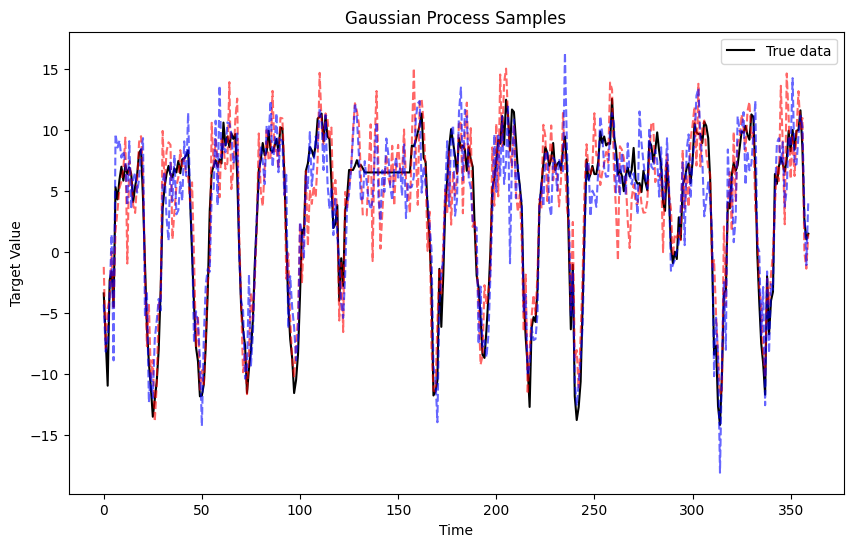

In [45]:
model.eval()  # Set model to evaluation mode
likelihood = model.likelihood

# Get posterior distribution
posterior = model.posterior(test_x)

# Sample from the posterior
num_samples = 5  # Change this to generate more samples
samples = posterior.rsample(torch.Size([num_samples]))  # Shape: (num_samples, test_x.size(0), 1)

# Convert to CPU for visualization
samples = samples.squeeze(-1).detach().cpu()

# Plot the samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k-', label="True data")

plt.plot(test_x.cpu().numpy(), samples[1].numpy(), 'r--', alpha=0.6)
plt.plot(test_x.cpu().numpy(), samples[2].numpy(), 'b--', alpha=0.6)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Target Value")
plt.title("Gaussian Process Samples")
plt.show()

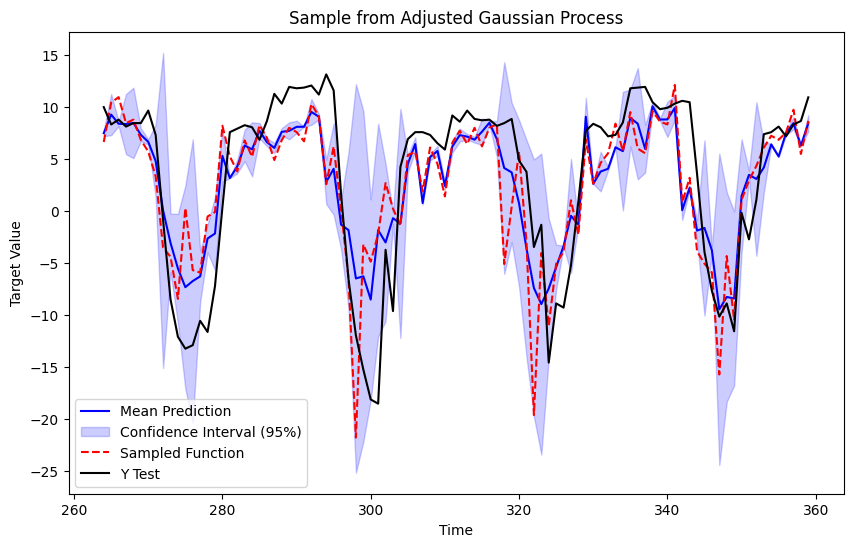

In [46]:
import torch
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal

model.eval()  # Ensure model is in evaluation mode

# 1. Compute the original kernel covariance matrix
kernel_matrix = model.covar_module(test_x).evaluate()

# Ensure mean_pred and std_pred are on the same device and correct dtype
mean_pred = torch.tensor(mean_pred).to(device).float()
std_pred = torch.tensor(std_pred).to(device).float()

# 1. Update the mean of the GP to match the mean predictions
updated_mean = mean_pred  # Shape: [test_x.size(0)]

test_x_filter = test_x[-len(mean_pred):]

# 2. Adjust the covariance matrix using the standard deviation predictions
updated_cov = model.covar_module(test_x_filter).evaluate() + torch.diag(std_pred**2)  # Convert std to variance and create diagonal covariance
# probably better ways to do this

# 3. Construct the updated Multivariate Normal distribution
new_posterior = MultivariateNormal(updated_mean, updated_cov)

# 4. Sample one realization from the adjusted GP
new_sample = new_posterior.rsample(torch.Size([1]))  # Shape: (1, test_x.size(0))

# Convert sample to CPU for visualization
new_sample = new_sample.squeeze(0).detach().cpu()

# Plot the new sample
plt.figure(figsize=(10, 6))
plt.plot(test_x_filter.cpu().numpy(), mean_pred.cpu().numpy(), 'b-', label="Mean Prediction")
plt.fill_between(test_x_filter.cpu().numpy().flatten(),
                 (mean_pred - 2 * std_pred).cpu().numpy(),
                 (mean_pred + 2 * std_pred).cpu().numpy(),
                 color="b", alpha=0.2, label="Confidence Interval (95%)")

# Plot the sampled function
plt.plot(test_x_filter.cpu().numpy(), new_sample.numpy(), 'r--', label="Sampled Function")
plt.plot(test_x[-len(mean_pred):].cpu().numpy(), test_y[-len(mean_pred):].cpu().numpy(), 'black', label="Y Test")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Target Value")
plt.title("Sample from Adjusted Gaussian Process")
plt.show()

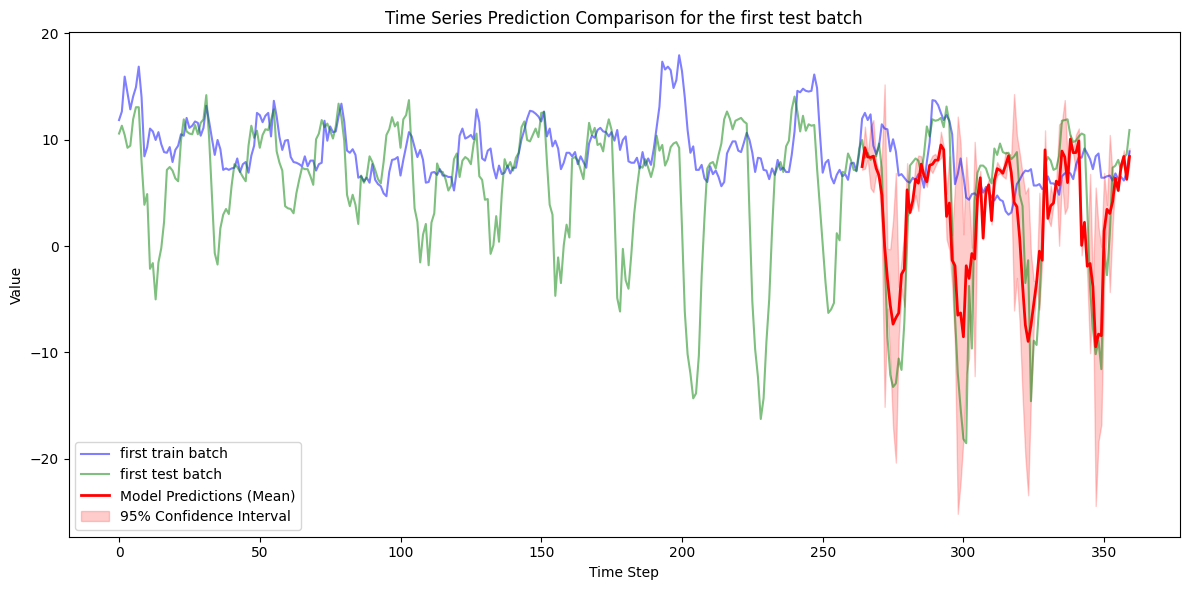

In [19]:
# refining the prediction
import numpy as np
plt.figure(figsize=(12, 6))

# Same plotting code as above
train_x_np = train_x.cpu().numpy()
train_y_np = train_y.cpu().numpy()
test_x_np = test_x.cpu().numpy()
test_y_np = test_y.cpu().numpy()
mean_pred_np = mean_pred#.cpu().numpy()
std_pred_np = std_pred#.cpu().numpy()

#plt.plot(train_x_np, train_y_np, color='blue', alpha=0.5, label='first train batch')
plt.plot(test_x_np, test_y_np, color='green', alpha=0.5, label='first test batch')
plt.plot(test_x_np[-len(mean_pred):], mean_pred_np, color='red', linewidth=2, label='Model Predictions (Mean)')
plt.fill_between(
    test_x_np[-len(mean_pred):], 
    mean_pred_np - 2 * std_pred_np, 
    mean_pred_np + 2 * std_pred_np, 
    color='red', 
    alpha=0.2, 
    label='95% Confidence Interval'
)

plt.title('Time Series Prediction Comparison for the first test batch')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.figure(figsize=(12, 6))

# Same plotting code as above
train_x_np = train_x.cpu().numpy()
train_y_np = train_y.cpu().numpy()
test_x_np = test_x.cpu().numpy()
test_y_np = test_y.cpu().numpy()
mean_pred_np = mean_pred#.cpu().numpy()
std_pred_np = std_pred#.cpu().numpy()

#plt.plot(train_x_np, train_y_np, color='blue', alpha=0.5, label='first train batch')
plt.plot(test_x_np, test_y_np, color='green', alpha=0.5, label='first test batch')
plt.plot(test_x_np[-len(mean_pred):], mean_pred_np, color='red', linewidth=2, label='Model Predictions (Mean)')
plt.fill_between(
    test_x_np[-len(mean_pred):], 
    mean_pred_np - 2 * std_pred_np, 
    mean_pred_np + 2 * std_pred_np, 
    color='red', 
    alpha=0.2, 
    label='95% Confidence Interval'
)

plt.title('Time Series Prediction Comparison for the first test batch')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
#plt.grid(True)

#rmse = np.sqrt(np.mean((mean_pred_np - test_y_np) ** 2))
#mae = np.mean(np.abs(mean_pred_np - test_y_np))

#metrics_text = f"RMSE: {rmse:.4f}\nMAE: {mae:.4f}"
#plt.figtext(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

# 11.3
- train the GP on one batch and one series
- then on first batch of test evaluate

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def get_data(data_loader):
    _iter = iter(data_loader) 
    first_batch = next(_iter)
    past_target = first_batch['past_target_cdf'].to(device)
    future_target = first_batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # batch_size, horizon, num_series = (32, 360, 7)

    num_series = 0
    targets = targets[0, :, num_series] #only select first batch/window at first (360, num_series)
    horizon_length = targets.shape[0]

    x = torch.arange(horizon_length).to(device) # [360]
    y = targets.to(device)  # [360, num_series]
    return x, y

train_dataloader = cli.datamodule.train_dataloader()
test_dataloader = cli.datamodule.test_dataloader()
train_x, train_y = get_data(train_dataloader)
test_x, test_y = get_data(test_dataloader)

mean_predictions, std_predictions = get_predictions_1(cli)[:2]
mean_pred = mean_predictions[0, :, 0]
std_pred = std_predictions[0, :, 0]

Using device: cuda
torch.Size([29, 264, 7])
torch.Size([29, 96, 7])
torch.Size([29, 96, 7])


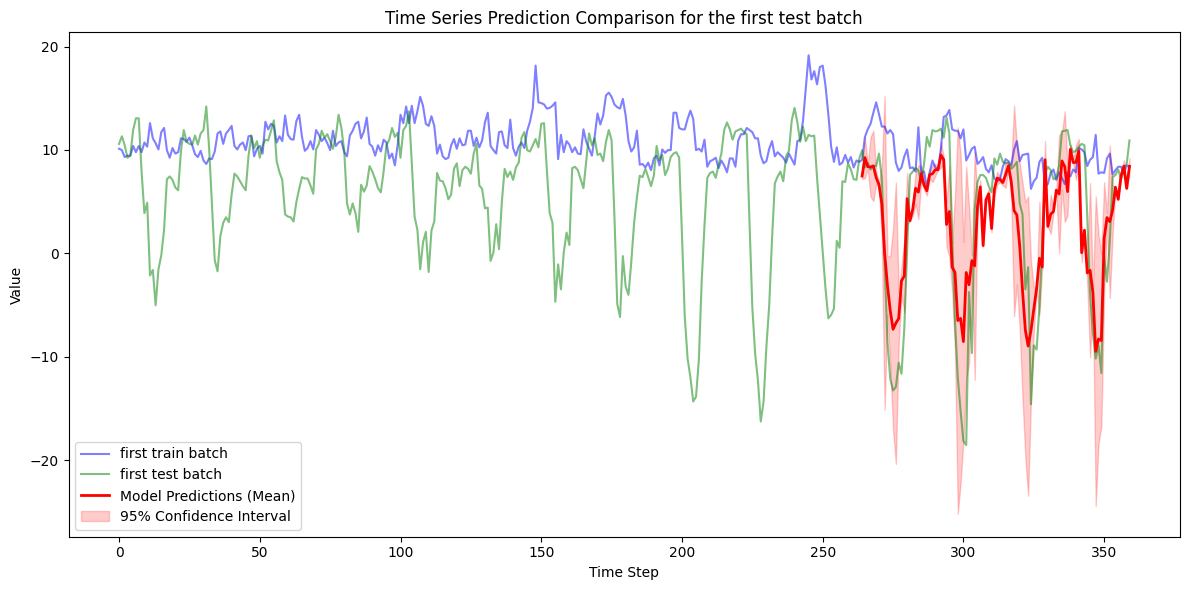

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))

# Same plotting code as above
train_x_np = train_x.cpu().numpy()
train_y_np = train_y.cpu().numpy()
test_x_np = test_x.cpu().numpy()
test_y_np = test_y.cpu().numpy()
mean_pred_np = mean_pred#.cpu().numpy()
std_pred_np = std_pred#.cpu().numpy()

plt.plot(train_x_np, train_y_np, color='blue', alpha=0.5, label='first train batch')
plt.plot(test_x_np, test_y_np, color='green', alpha=0.5, label='first test batch')
plt.plot(test_x_np[-len(mean_pred):], mean_pred_np, color='red', linewidth=2, label='Model Predictions (Mean)')
plt.fill_between(
    test_x_np[-len(mean_pred):], 
    mean_pred_np - 2 * std_pred_np, 
    mean_pred_np + 2 * std_pred_np, 
    color='red', 
    alpha=0.2, 
    label='95% Confidence Interval'
)

plt.title('Time Series Prediction Comparison for the first test batch')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
#plt.grid(True)

#rmse = np.sqrt(np.mean((mean_pred_np - test_y_np) ** 2))
#mae = np.mean(np.abs(mean_pred_np - test_y_np))

#metrics_text = f"RMSE: {rmse:.4f}\nMAE: {mae:.4f}"
#plt.figtext(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

In [32]:
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, MaternKernel, PeriodicKernel, ScaleKernel
import time
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_type="RBF"):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        
        # Define kernel
        if kernel_type == "RBF":
            self.covar_module = ScaleKernel(RBFKernel())
        elif kernel_type == "Matern32":
            self.covar_module = ScaleKernel(MaternKernel(nu=1.5))
        elif kernel_type == "Matern52":
            self.covar_module = ScaleKernel(MaternKernel(nu=2.5))
        elif kernel_type == "Periodic":
            self.covar_module = ScaleKernel(PeriodicKernel())
        else:
            raise ValueError(f"Unsupported kernel type: {kernel_type}")
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_with_gpytorch(X_train, y_train, kernel_type="RBF", num_iterations=100):
    """
    Train a Gaussian Process using GPyTorch.
    
    Parameters:
    -----------
    X_train : numpy.ndarray
        Input training data with shape (n_samples, n_features)
    y_train : numpy.ndarray
        Target training data with shape (n_samples,)
    kernel_type : str
        Type of kernel to use (default: "RBF")
    num_iterations : int
        Number of training iterations (default: 100)
    
    Returns:
    --------
    model : GPModel
        Trained Gaussian Process model
    likelihood : GaussianLikelihood
        Trained likelihood
    train_time : float
        Time taken to train the model in seconds
    """
    start_time = time.time()
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device='cuda:0')
    y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.float32).to(device='cuda:0')
    
    # Initialize likelihood and model
    likelihood = GaussianLikelihood().to(device='cuda:0')
    model = GPModel(X_train_tensor, y_train_tensor, likelihood, kernel_type=kernel_type).to(device='cuda:0')
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
    ], lr=0.1)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
        loss.backward()
        if (i+1) % 10 == 0:
            print(f'Iteration {i+1}/{num_iterations} - Loss: {loss.item():.3f}')
        optimizer.step()
    
    end_time = time.time()
    train_time = end_time - start_time
    
    # Set the model to evaluation mode
    model.eval()
    likelihood.eval()
    
    return model, likelihood, train_time

Iteration 10/100 - Loss: 11.808
Iteration 20/100 - Loss: 6.170
Iteration 30/100 - Loss: 4.447
Iteration 40/100 - Loss: 3.723
Iteration 50/100 - Loss: 3.334
Iteration 60/100 - Loss: 3.084
Iteration 70/100 - Loss: 2.903
Iteration 80/100 - Loss: 2.761
Iteration 90/100 - Loss: 2.645
Iteration 100/100 - Loss: 2.546
GPyTorch Model Parameters:
likelihood.noise_covar.raw_noise: 1.7913
mean_module.raw_constant: 4.0850
covar_module.raw_outputscale: 3.1607
covar_module.base_kernel.raw_lengthscale: 3.2194
Training time: 0.7743 seconds
(360, 1)
(360,)


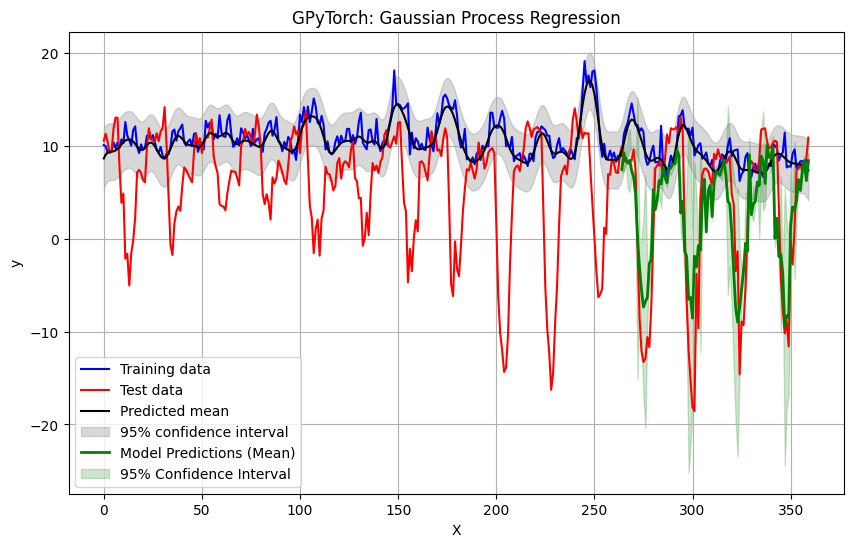

3

In [50]:
def gpytorch_demo(train_x, train_y, test_x, test_y, mean_pred_np, std_pred_np):
    # Generate some synthetic time series data
    np.random.seed(42)
    
    # Train GP model
    model, likelihood, train_time = train_gp_with_gpytorch(train_x, train_y, kernel_type="RBF", num_iterations=100)
    model = model.to('cpu')
    likelihood = likelihood.to('cpu')
    #train_x, train_y, test_x, test_y = train_x.cpu().numpy(), train_y.cpu().numpy(), test_x.cpu().numpy(), test_y.cpu().numpy()
    # Print model parameters
    print("GPyTorch Model Parameters:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.item():.4f}")
    print(f"Training time: {train_time:.4f} seconds")
    
    # Make predictions
    test_x_tensor = torch.tensor(test_x, dtype=torch.float32).to('cpu')
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        y_pred_dist = likelihood(model(test_x_tensor))
        y_pred = y_pred_dist.mean.numpy().reshape(-1, 1)
        y_std = y_pred_dist.stddev.numpy().reshape(-1, 1)
        print(y_pred.shape)
        print(test_x.shape)
    
    # Calculate RMSE
    #rmse = np.sqrt(np.mean((y_pred - test_y) ** 2))
    #print(f"Test RMSE: {rmse:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(train_x, train_y, color='blue', label='Training data')
    plt.plot(test_x, test_y, color='red', label='Test data')
    
    plt.plot(test_x, y_pred, 'k-', label='Predicted mean')
    plt.fill_between(test_x.flatten(), 
                     (y_pred - 2 * y_std).flatten(), 
                     (y_pred + 2 * y_std).flatten(), 
                     color='gray', alpha=0.3, 
                     label='95% confidence interval')

    plt.plot(test_x[-len(mean_pred):], mean_pred_np, color='green', linewidth=2, label='Model Predictions (Mean)')
    plt.fill_between(
        test_x[-len(mean_pred):], 
        mean_pred_np - 2 * std_pred_np, 
        mean_pred_np + 2 * std_pred_np, 
        color='green', 
        alpha=0.2, 
        label='95% Confidence Interval'
    )
    
    plt.title('GPyTorch: Gaussian Process Regression')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()
    return model, likelihood, train_x, train_y, test_x, test_y, y_pred, y_std
    
model, likelihood, train_x, train_y, test_x, test_y, y_pred, y_std = gpytorch_demo(train_x, train_y, test_x, test_y, mean_pred_np, std_pred_np)
3

Iteration 10/100 - Loss: 11.808
Iteration 20/100 - Loss: 6.170
Iteration 30/100 - Loss: 4.447
Iteration 40/100 - Loss: 3.723
Iteration 50/100 - Loss: 3.334
Iteration 60/100 - Loss: 3.084
Iteration 70/100 - Loss: 2.903
Iteration 80/100 - Loss: 2.761
Iteration 90/100 - Loss: 2.645
Iteration 100/100 - Loss: 2.546
GPyTorch Model Parameters:
likelihood.noise_covar.raw_noise: 1.7913
mean_module.raw_constant: 4.0850
covar_module.raw_outputscale: 3.1607
covar_module.base_kernel.raw_lengthscale: 3.2194
Training time: 0.7501 seconds
(360, 1)
(360,)


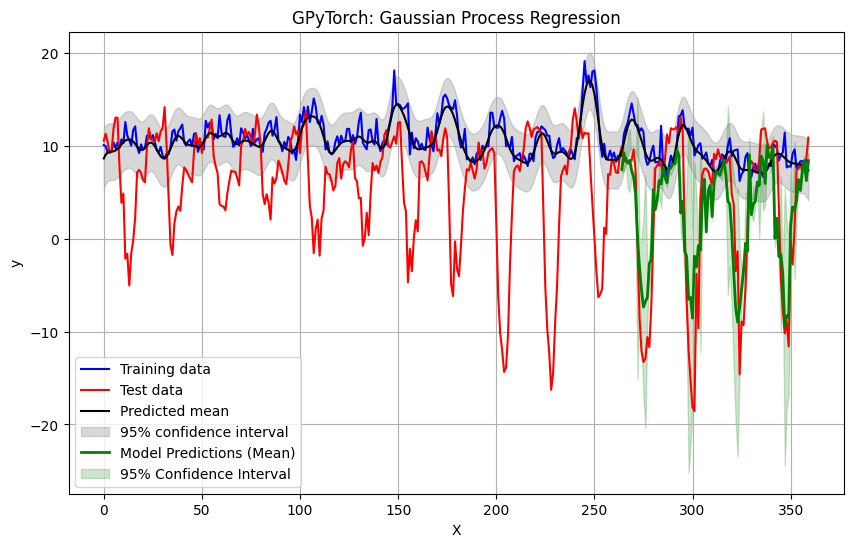

(5, 96)


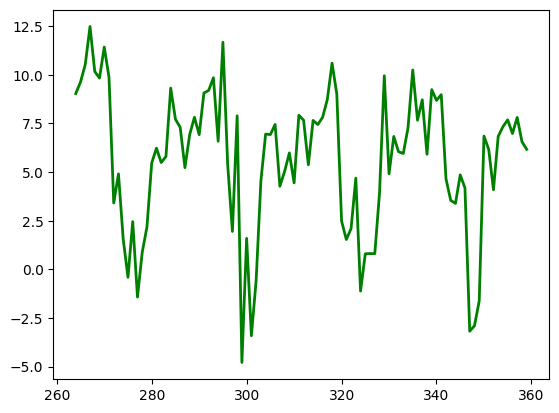

In [55]:
model, likelihood, train_x, train_y, test_x, test_y, y_pred, y_std = gpytorch_demo(train_x, train_y, test_x, test_y, mean_pred_np, std_pred_np)
def generate_gp_sample(model, likelihood, test_x, mean_pred_np, std_pred_np, num_samples=1):
    """
    Generate a sample from the trained Gaussian Process conditioned on the predictions
    of another model's mean and standard deviation, using the trained GP parameters.
    
    Parameters:
        model: Trained GPyTorch model
        likelihood: Likelihood function associated with the model
        test_x: Test input points
        mean_pred_np: Mean predictions from another model
        std_pred_np: Standard deviation predictions from another model
        num_samples: Number of samples to generate
        
    Returns:
        gp_samples: Generated samples from the GP posterior
    """
    model.eval()
    likelihood.eval()
    
    # Convert test_x to tensor
    test_x_tensor = torch.tensor(test_x, dtype=torch.float32).to('cpu')
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Use the trained GP parameters to make predictions
        model.covar_module.outputscale = model.covar_module.outputscale.item()
        model.covar_module.base_kernel.lengthscale = model.covar_module.base_kernel.lengthscale.item()
        
        y_pred_dist = likelihood(model(test_x_tensor[-len(mean_pred_np):]))
        y_pred_mean = y_pred_dist.mean.numpy()
        y_pred_std = y_pred_dist.stddev.numpy()
        
        # Condition GP samples on mean_pred_np and std_pred_np
        conditioned_mean = (y_pred_mean + mean_pred_np) / 2
        conditioned_std = np.sqrt((y_pred_std**2 + std_pred_np**2) / 2)
        
        # Sample from the conditioned distribution
        gp_samples = conditioned_mean + conditioned_std * np.random.randn(num_samples, *conditioned_mean.shape)
    
    return gp_samples

# Example usage:
gp_samples = generate_gp_sample(model, likelihood, test_x, mean_pred_np, std_pred_np, num_samples=5)
print(gp_samples.shape)  # Expected shape: (5, len(test_x))
plt.plot(test_x[-len(mean_pred):], gp_samples[0][-len(mean_pred):], color='green', linewidth=2, label='Model Predictions (Mean)')
plt.show()

Prior covariance matrix computed in 0.0038 seconds
Posterior covariance matrix shape: torch.Size([360, 360])


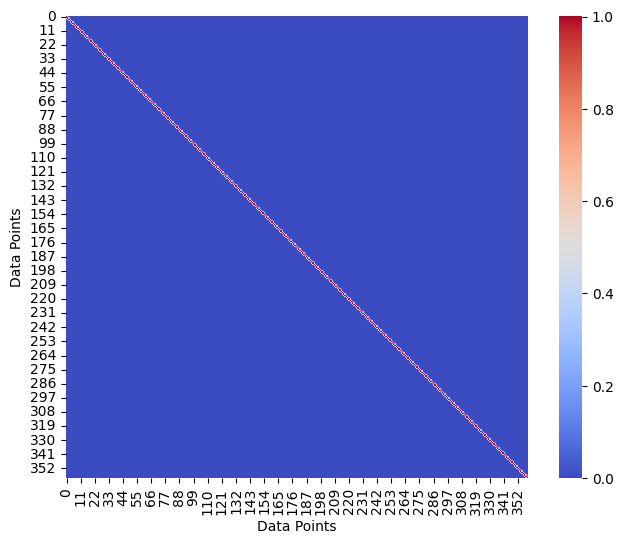

In [65]:
import time
import torch
import gpytorch

def get_posterior_gp_covariance_matrix(X_train, y_train, kernel_type="RBF", noise_variance=1e-3, without_y=True):
    """
    Compute the posterior covariance matrix of a Gaussian Process conditioned on training data.
    
    Parameters:
    -----------
    X_train : numpy.ndarray
        Input training data with shape (n_samples, n_features)
    y_train : numpy.ndarray
        Target training data with shape (n_samples,)
    kernel_type : str
        Type of kernel to use (default: "RBF")
    noise_variance : float
        Noise variance term (default: 1e-3)
    
    Returns:
    --------
    posterior_covariance_matrix : torch.Tensor
        Posterior covariance matrix of the GP
    model : GPModel
        Trained Gaussian Process model
    """
    start_time = time.time()
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device='cuda:0')
    y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.float32).to(device='cuda:0')

    if without_y:    
        ## Create a kernel function without defining a full GP model
        kernel = gpytorch.kernels.RBFKernel().to(device='cuda:0')  # You can change to other kernels if needed
        K_xx = kernel(X_train_tensor, X_train_tensor).evaluate()
    
        # Add noise term
        noise_matrix = noise_variance * torch.eye(K_xx.shape[0], device='cuda:0')
        prior_covariance_matrix = K_xx + noise_matrix
    
        end_time = time.time()
        compute_time = end_time - start_time
        print(f"Prior covariance matrix computed in {compute_time:.4f} seconds")
    
        return prior_covariance_matrix.detach()
    else:
        # Initialize the GP model
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device='cuda:0')
        model = GPModel(X_train_tensor, y_train_tensor, likelihood, kernel_type=kernel_type).to(device='cuda:0')
        model.eval()
        likelihood.eval()
    
        # Compute kernel covariance K(X, X)
        with torch.no_grad():
            K_xx = model.covar_module(X_train_tensor).evaluate()
            noise_matrix = noise_variance * torch.eye(K_xx.shape[0], device='cuda:0')
    
            # Compute posterior covariance matrix
            K_inv = torch.inverse(K_xx + noise_matrix)
            posterior_covariance_matrix = K_xx - K_xx @ K_inv @ K_xx
    
        end_time = time.time()
        compute_time = end_time - start_time
        print(f"Posterior covariance matrix computed in {compute_time:.4f} seconds")
    
        return posterior_covariance_matrix#, model

# Example usage:
posterior_cov_matrix = get_posterior_gp_covariance_matrix(train_x, train_y, without_y=True)
print("Posterior covariance matrix shape:", posterior_cov_matrix.shape)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(posterior_cov_matrix.to('cpu'), cmap="coolwarm", square=True, cbar=True)
plt.xlabel("Data Points")
plt.ylabel("Data Points")
plt.show()


In [47]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from gpytorch.distributions import MultivariateNormal

def generate_samples_from_gp_conditioning_on_model(
    trained_model,
    trained_likelihood,
    train_x,
    train_y,
    other_model_x, 
    other_model_mean, 
    other_model_std,
    num_samples=10,
    full_x=None
):
    """
    Generate samples from a trained GP conditioned on predictions from another model
    
    Parameters:
    -----------
    trained_model : gpytorch.models.ExactGP
        The trained GP model
    trained_likelihood : gpytorch.likelihoods.GaussianLikelihood
        The trained likelihood
    train_x : torch.Tensor
        Training input data
    train_y : torch.Tensor
        Training target data
    other_model_x : torch.Tensor
        Input locations where the other model made predictions
    other_model_mean : torch.Tensor or numpy.ndarray
        Mean predictions from the other model
    other_model_std : torch.Tensor or numpy.ndarray
        Standard deviation of predictions from the other model
    num_samples : int
        Number of samples to generate
    full_x : torch.Tensor, optional
        All input locations where samples should be generated
        
    Returns:
    --------
    torch.Tensor
        Generated samples with shape [num_samples, len(full_x)]
    """
    # Ensure everything is on the same device
    device = next(trained_model.parameters()).device
    
    # Convert numpy arrays to tensors if needed
    if isinstance(other_model_mean, np.ndarray):
        other_model_mean = torch.tensor(other_model_mean, dtype=torch.float32).to(device)
    if isinstance(other_model_std, np.ndarray):
        other_model_std = torch.tensor(other_model_std, dtype=torch.float32).to(device)
    if isinstance(other_model_x, np.ndarray):
        other_model_x = torch.tensor(other_model_x, dtype=torch.float32).to(device)
    
    # If full_x is not provided, use the union of train_x and other_model_x
    if full_x is None:
        if isinstance(train_x, np.ndarray):
            train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
        
        all_x_points = torch.cat([train_x, other_model_x])
        full_x, indices = torch.unique(all_x_points, return_inverse=True)
        full_x = full_x.to(device)
    
    # Set the model to evaluation mode
    trained_model.eval()
    trained_likelihood.eval()
    
    # Get the covariance matrix from the kernel for all points
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Extract the kernel and get the covariance matrices
        covar_module = trained_model.covar_module
        
        # Get the prior covariance for all points
        K_full = covar_module(full_x).evaluate()
        
        # Get the noise variance
        noise_var = trained_likelihood.noise.item()
        
        # Extract indices in full_x that correspond to other_model predictions
        if isinstance(other_model_x, np.ndarray):
            other_model_x = torch.tensor(other_model_x, dtype=torch.float32).to(device)
        
        # Find indices of other_model_x within full_x
        # This is an approximate approach for floating point values
        other_model_indices = []
        for x in other_model_x:
            # Find the closest index
            idx = torch.argmin(torch.abs(full_x - x))
            other_model_indices.append(idx)
        
        other_model_indices = torch.tensor(other_model_indices, dtype=torch.long).to(device)
        
        # Get the covariance matrices we need
        K_oo = K_full[other_model_indices][:, other_model_indices]  # Other model points to other model points
        K_fo = K_full[:, other_model_indices]  # Full points to other model points
        
        # Add observation noise variance from the other model
        # We convert the std to variance and add it to the diagonal
        other_model_var = other_model_std ** 2
        K_oo_with_noise = K_oo + torch.diag(other_model_var.squeeze())
        
        # Calculate the conditional distribution
        # p(f | other_model_data) = N(μ, Σ)
        # μ = K_fo @ K_oo^(-1) @ other_model_mean
        # Σ = K_full - K_fo @ K_oo^(-1) @ K_fo.T
        
        # Compute K_oo^(-1) @ other_model_mean
        L = torch.linalg.cholesky(K_oo_with_noise)
        
        #alpha = torch.cholesky_solve(other_model_mean.unsqueeze(-1), L).squeeze(-1)
        # With:
        # Reshape other_model_mean to make it compatible with L
        if other_model_mean.ndim == 1:
            other_model_mean = other_model_mean.reshape(-1, 1)
        elif other_model_mean.shape[1] != 1 and other_model_mean.shape[0] == L.shape[0]:
            other_model_mean = other_model_mean.reshape(-1, 1)
            
        alpha = torch.cholesky_solve(other_model_mean, L).squeeze(-1)
        
        # Compute the conditional mean: K_fo @ alpha
        cond_mean = torch.matmul(K_fo, alpha)
        
        # Compute the conditional covariance: K_full - K_fo @ K_oo^(-1) @ K_fo.T
        tmp = torch.triangular_solve(K_fo.T, L, upper=False)[0]
        cond_cov = K_full - torch.matmul(tmp.T, tmp)
        
        # Add a small jitter to the diagonal for numerical stability
        cond_cov = cond_cov + torch.eye(cond_cov.shape[0], device=device) * 1e-6
        
        # Create a MultivariateNormal distribution for the conditional
        cond_dist = MultivariateNormal(cond_mean, cond_cov)
        
        # Sample from the conditional distribution
        samples = cond_dist.sample(torch.Size([num_samples]))
    
    return samples, cond_mean, torch.diagonal(cond_cov).sqrt()

def plot_conditional_samples(
    train_x, 
    train_y, 
    other_model_x, 
    other_model_mean, 
    other_model_std,
    full_x,
    samples,
    cond_mean,
    cond_std
):
    """Plot the samples from the conditional GP"""
    # Convert to numpy for plotting
    if torch.is_tensor(train_x):
        train_x = train_x.cpu().numpy()
    if torch.is_tensor(train_y):
        train_y = train_y.cpu().numpy()
    if torch.is_tensor(other_model_x):
        other_model_x = other_model_x.cpu().numpy()
    if torch.is_tensor(other_model_mean):
        other_model_mean = other_model_mean.cpu().numpy()
    if torch.is_tensor(other_model_std):
        other_model_std = other_model_std.cpu().numpy()
    if torch.is_tensor(full_x):
        full_x = full_x.cpu().numpy()
    if torch.is_tensor(samples):
        samples = samples.cpu().numpy()
    if torch.is_tensor(cond_mean):
        cond_mean = cond_mean.cpu().numpy()
    if torch.is_tensor(cond_std):
        cond_std = cond_std.cpu().numpy()
    
    # Make sure arrays are the right shape
    if len(train_x.shape) > 1 and train_x.shape[1] == 1:
        train_x = train_x.flatten()
    if len(train_y.shape) > 1 and train_y.shape[1] == 1:
        train_y = train_y.flatten()
    if len(other_model_x.shape) > 1 and other_model_x.shape[1] == 1:
        other_model_x = other_model_x.flatten()
    if len(other_model_mean.shape) > 1 and other_model_mean.shape[1] == 1:
        other_model_mean = other_model_mean.flatten()
    if len(other_model_std.shape) > 1 and other_model_std.shape[1] == 1:
        other_model_std = other_model_std.flatten()
    if len(full_x.shape) > 1 and full_x.shape[1] == 1:
        full_x = full_x.flatten()
    if len(cond_mean.shape) > 1 and cond_mean.shape[1] == 1:
        cond_mean = cond_mean.flatten()
    if len(cond_std.shape) > 1 and cond_std.shape[1] == 1:
        cond_std = cond_std.flatten()
    
    plt.figure(figsize=(12, 8))
    
    # Plot training data
    plt.scatter(train_x, train_y, color='blue', alpha=0.6, label='Training Data')
    
    # Plot other model's predictions with uncertainty
    plt.plot(other_model_x, other_model_mean, 'g-', linewidth=2, label='Other Model Mean')
    plt.fill_between(
        other_model_x, 
        other_model_mean - 2 * other_model_std, 
        other_model_mean + 2 * other_model_std, 
        color='green', 
        alpha=0.2, 
        label='Other Model 95% CI'
    )
    
    # Plot conditional GP mean and uncertainty
    plt.plot(full_x, cond_mean, 'r-', linewidth=2, label='Conditional GP Mean')
    plt.fill_between(
        full_x, 
        cond_mean - 2 * cond_std, 
        cond_mean + 2 * cond_std, 
        color='red', 
        alpha=0.2, 
        label='Conditional GP 95% CI'
    )
    
    # Plot samples from the conditional GP
    for i in range(samples.shape[0]):
        plt.plot(full_x, samples[i], 'k-', alpha=0.2, linewidth=1)
        
    # Add a few sample curves to the legend (just showing one in the legend for clarity)
    plt.plot([], [], 'k-', alpha=0.5, linewidth=1, label='Conditional GP Samples')
    
    plt.title('Samples from GP Conditioned on Another Model\'s Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def demonstrate_conditional_sampling():
    """Example of using the conditional sampling with a toy dataset"""
    # Create some toy data for illustration
    np.random.seed(42)
    train_x = np.sort(np.random.rand(30) * 10)
    train_y = np.sin(train_x) + 0.1 * np.random.randn(len(train_x))
    
    # Convert to tensors
    train_x_tensor = torch.tensor(train_x, dtype=torch.float32).reshape(-1, 1)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    
    # Train a GPyTorch model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    model = ExactGPModel(train_x_tensor, train_y_tensor, likelihood)
    
    # Train the model
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(100):
        optimizer.zero_grad()
        output = model(train_x_tensor)
        loss = -mll(output, train_y_tensor)
        loss.backward()
        optimizer.step()
    
    # Create some other model predictions
    other_model_x = np.linspace(5, 15, 20)  # Note: extends beyond training range
    other_model_mean = np.sin(other_model_x) + 0.5  # Biased predictions
    other_model_std = 0.2 + 0.02 * np.arange(len(other_model_x))  # Increasing uncertainty
    
    # Convert to tensors
    other_model_x_tensor = torch.tensor(other_model_x, dtype=torch.float32).reshape(-1, 1)
    other_model_mean_tensor = torch.tensor(other_model_mean, dtype=torch.float32).reshape(-1, 1)
    other_model_std_tensor = torch.tensor(other_model_std, dtype=torch.float32).reshape(-1, 1)
    
    # Generate full x range for sampling
    full_x = np.linspace(0, 15, 200)
    full_x_tensor = torch.tensor(full_x, dtype=torch.float32).reshape(-1, 1)
    
    # Generate conditional samples
    samples, cond_mean, cond_std = generate_samples_from_gp_conditioning_on_model(
        model,
        likelihood,
        train_x_tensor,
        train_y_tensor,
        other_model_x_tensor,
        other_model_mean_tensor,
        other_model_std_tensor,
        num_samples=10,
        full_x=full_x_tensor
    )
    
    # Plot the results
    plot_conditional_samples(
        train_x_tensor, 
        train_y_tensor, 
        other_model_x_tensor, 
        other_model_mean_tensor, 
        other_model_std_tensor,
        full_x_tensor,
        samples,
        cond_mean,
        cond_std
    )
    
    return model, likelihood, samples, cond_mean, cond_std

# Example usage with your specific variables:
def condition_gp_on_your_model(trained_model, trained_likelihood, train_x, train_y, test_x, mean_pred_np, std_pred_np):
    """Apply conditional sampling with your specific variables"""
    # Convert numpy arrays to tensors if needed
    if not torch.is_tensor(train_x):
        train_x = torch.tensor(train_x, dtype=torch.float32).reshape(-1, 1)
    if not torch.is_tensor(train_y):
        train_y = torch.tensor(train_y, dtype=torch.float32)
    if not torch.is_tensor(test_x):
        test_x = torch.tensor(test_x, dtype=torch.float32).reshape(-1, 1)
    
    # Get the input locations for your model's predictions
    other_model_x = test_x[-len(mean_pred_np):]
    
    # Ensure mean_pred_np and std_pred_np are tensors
    if not torch.is_tensor(mean_pred_np):
        mean_pred_np = torch.tensor(mean_pred_np, dtype=torch.float32).reshape(-1, 1)
    if not torch.is_tensor(std_pred_np):
        std_pred_np = torch.tensor(std_pred_np, dtype=torch.float32).reshape(-1, 1)
    
    # You may want to normalize your data if it's not already
    
    # Generate full range of x values for sampling
    full_x = torch.cat([train_x, test_x])
    full_x, _ = torch.sort(torch.unique(full_x, dim=0), dim=0)
    
    # Generate conditional samples
    samples, cond_mean, cond_std = generate_samples_from_gp_conditioning_on_model(
        trained_model,
        trained_likelihood,
        train_x,
        train_y,
        other_model_x,
        mean_pred_np,
        std_pred_np,
        num_samples=10,
        full_x=full_x
    )
    
    # Plot the results
    plot_conditional_samples(
        train_x, 
        train_y, 
        other_model_x, 
        mean_pred_np, 
        std_pred_np,
        full_x,
        samples,
        cond_mean,
        cond_std
    )
    
    return samples, cond_mean, cond_std



#if __name__ == "__main__":
    # Run the demonstration function to see how it works
    # Or call condition_gp_on_your_model with your actual model and data
demonstrate_conditional_sampling()

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 7 is not positive-definite).

# GPytorch 2

In [15]:
import torch
import gpytorch
from tqdm import tqdm

# Define the Batch GP Model
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_series):
        super().__init__(train_x, train_y, likelihood)
        
        self.num_series = num_series
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_series]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_series])),
            batch_shape=torch.Size([num_series])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_loader = cli.datamodule.train_dataloader()
batch_size, horizon, num_series = 32, 360, 7 # shape of batches

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_series).to(device)
model = BatchIndependentMultitaskGPModel(None, None, likelihood, num_series).to(device)

# Function to train the batch GP
def train_batch_gp(model, likelihood, train_x, train_y, num_iter=5):
    # Move data to GPU
    train_x, train_y = train_x.to(device), train_y.to(device)
    
    model.set_train_data(train_x, train_y, strict=False)  # Update training data
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

total = 1000
for i, batch in tqdm(enumerate(train_loader), total=total):  # Assume dataloader yields (batch_size, horizon_length, 7)
    if i>total:
        break
    past_target = batch['past_target_cdf'].to(device)
    future_target = batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
    targets = targets[0, :, :] #only select first batch/window at first
    #batch_size, 
    horizon_length, num_series = targets.shape
    
    train_x = torch.arange(horizon_length).to(device) # [360]
    train_y = targets.to(device)  # Move num_series first, then flatten, [360,7]

    train_batch_gp(model, likelihood, train_x, train_y)

Using device: cuda


1001it [04:24,  3.79it/s]                                                                                                                                                              


In [16]:
# Predict using the trained Batch GP
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    test_x = test_x.to(device)  # Move test data to GPU
    with torch.no_grad():
        pred = likelihood(model(test_x))
    mean = pred.mean.cpu()  # Extract mean and move to CPU
    lower, upper = pred.confidence_region()  # Get confidence intervals
    
    return mean, lower.cpu(), upper.cpu()

test_dataloader = cli.datamodule.test_dataloader()
train_iter = iter(test_dataloader)  # Create an iterator
first_batch = next(train_iter)   # Get the first batch
past_target = first_batch['past_target_cdf'].to(device)
future_target = first_batch['future_target_cdf'].to(device)
targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
targets = targets[0, :, :] #only select first batch/window at first
batch_size, 
horizon_length, num_series = targets.shape

test_x = torch.arange(horizon_length).to(device) # [360]
test_y = targets.to(device)  # Move num_series first, then flatten, [360,7]

mean, lower, upper = predict(model, likelihood, test_x)

## fit on the first 1000 batches

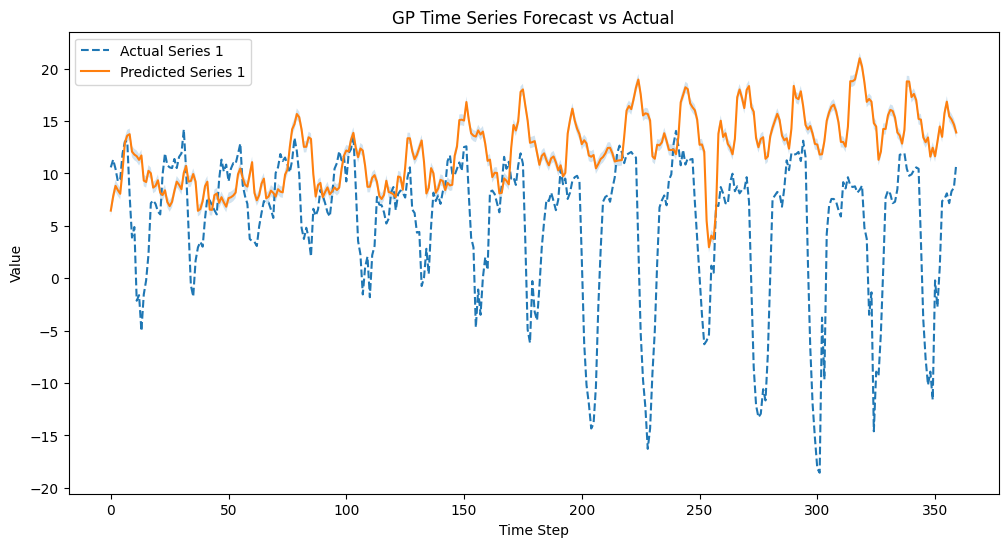

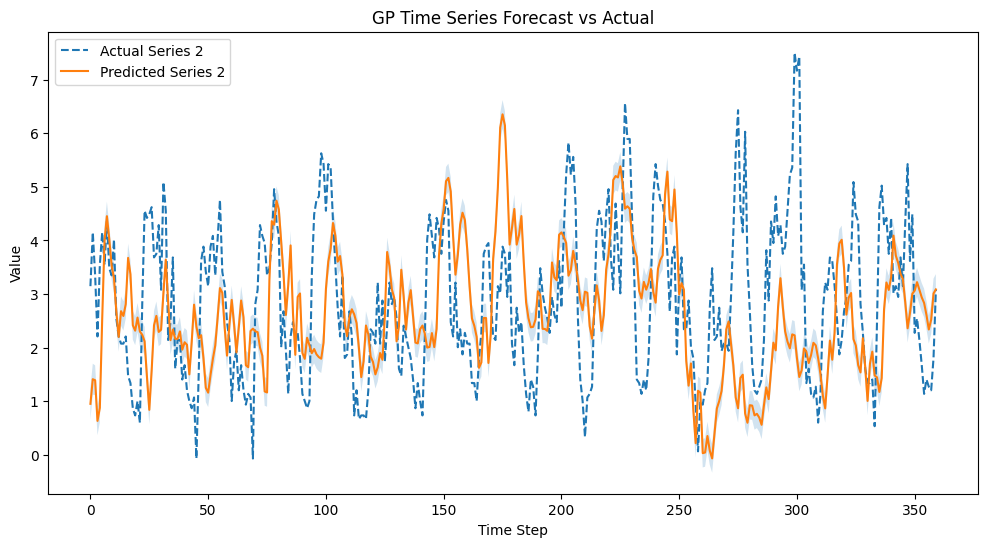

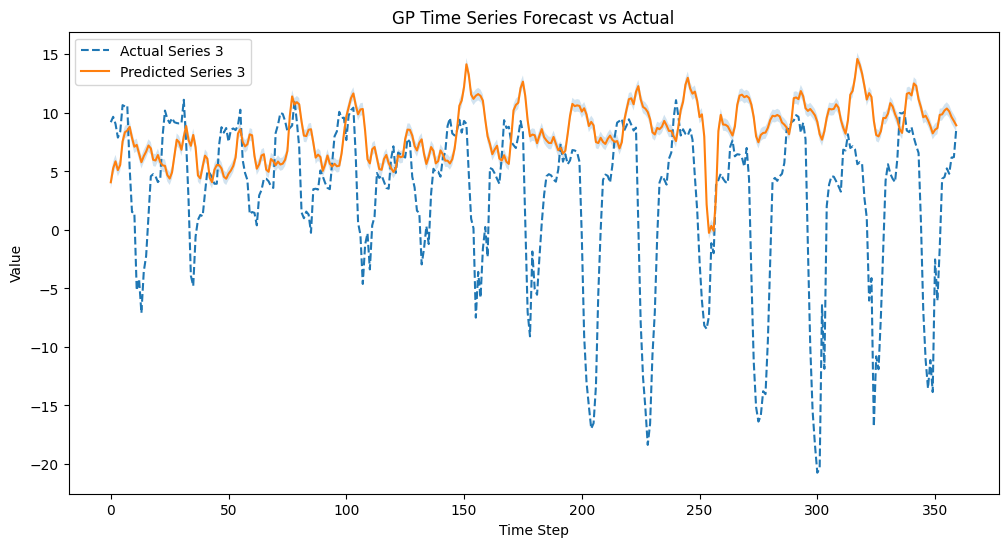

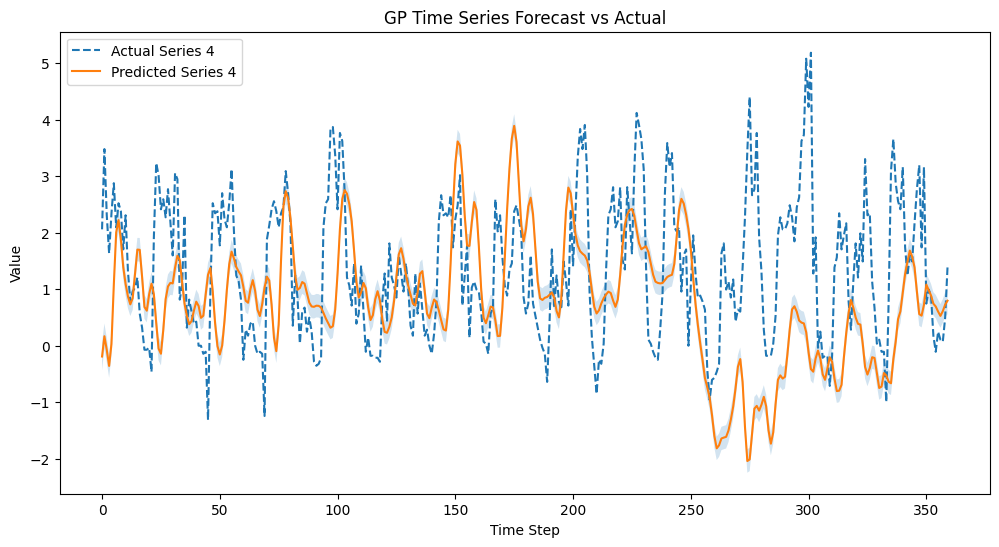

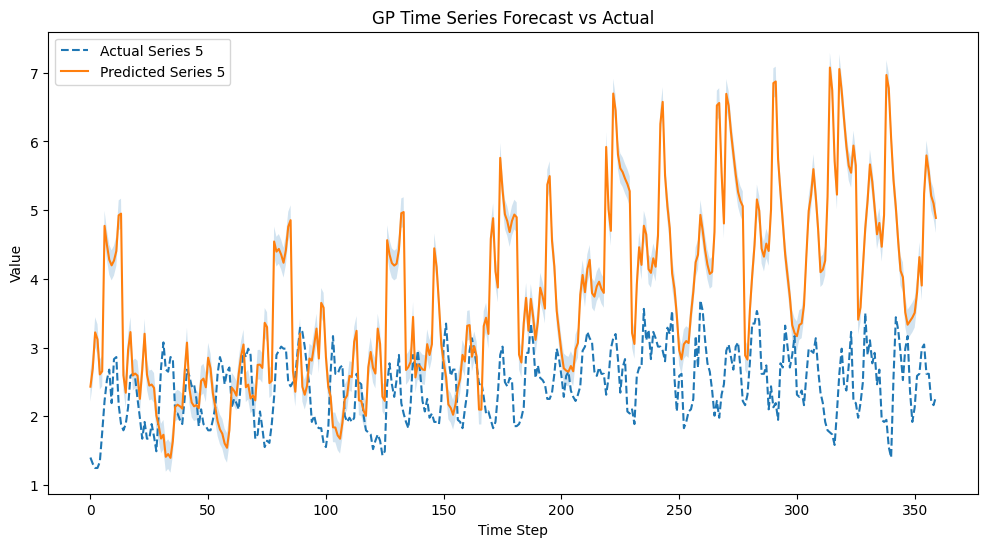

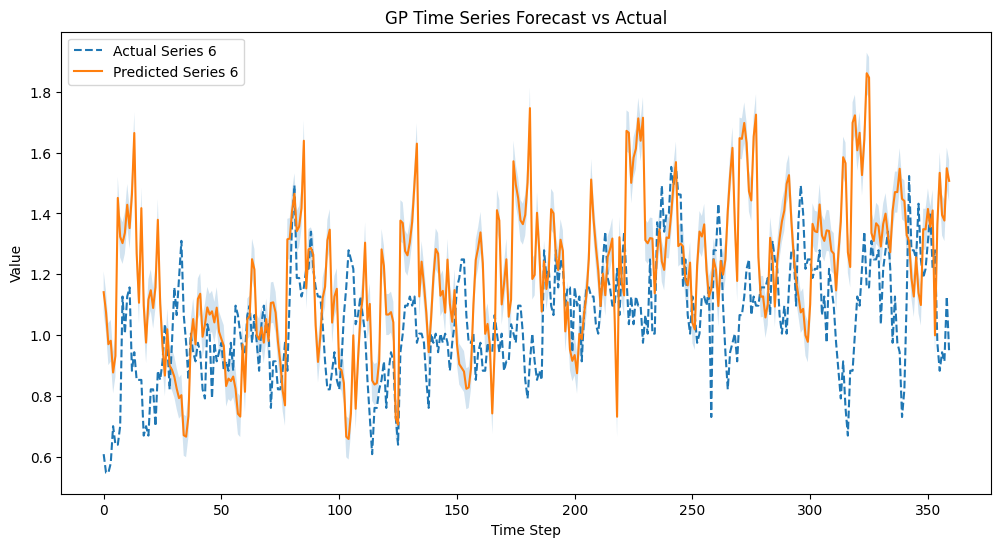

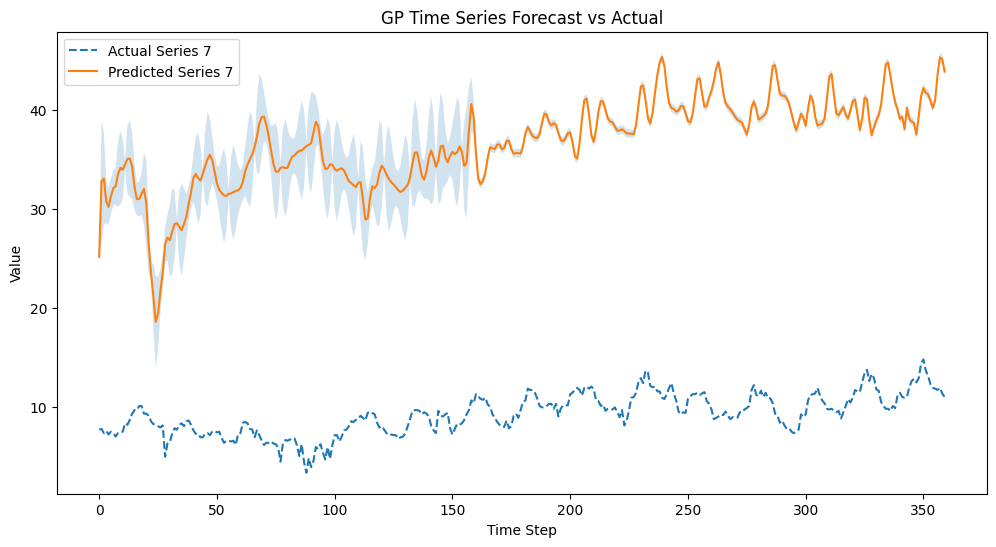

In [17]:
import matplotlib.pyplot as plt

# Ensure data is on CPU
test_x_cpu = test_x.cpu()
test_y_cpu = test_y.cpu()
mean_cpu = mean.cpu()
lower_cpu = lower.cpu()
upper_cpu = upper.cpu()

# Plot each series independently
for i in range(num_series):
    plt.figure(figsize=(12, 6))
    plt.plot(test_x_cpu, test_y_cpu[:, i], label=f"Actual Series {i+1}", linestyle="dashed")
    plt.plot(test_x_cpu, mean_cpu[:, i], label=f"Predicted Series {i+1}")
    plt.fill_between(test_x_cpu, lower_cpu[:, i], upper_cpu[:, i], alpha=0.2)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("GP Time Series Forecast vs Actual")
    plt.legend()
    plt.show()

## fit on the first 100 batches

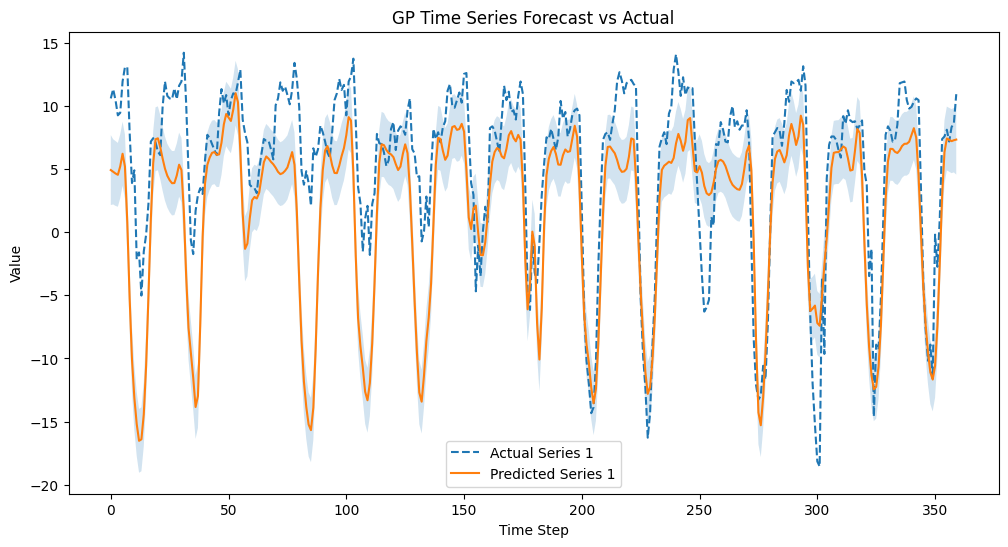

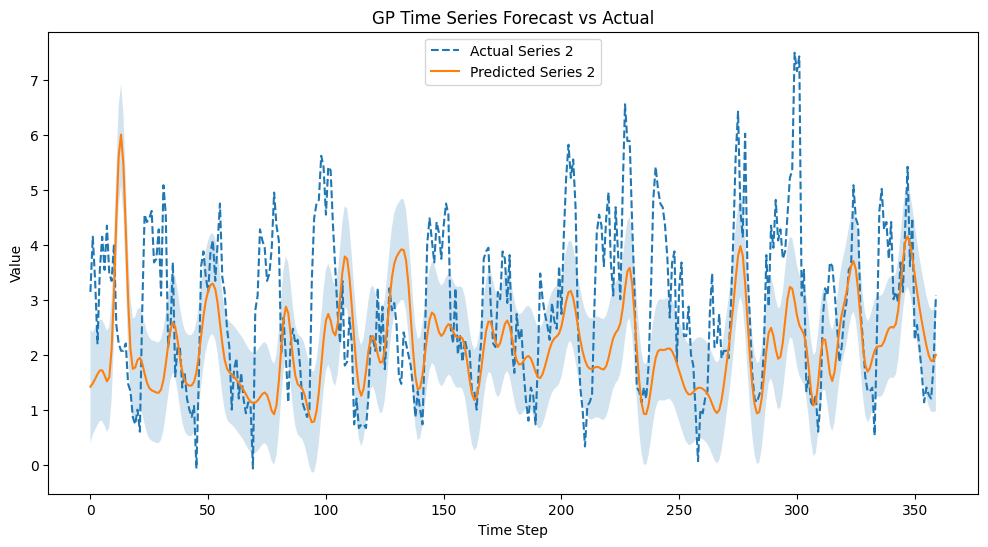

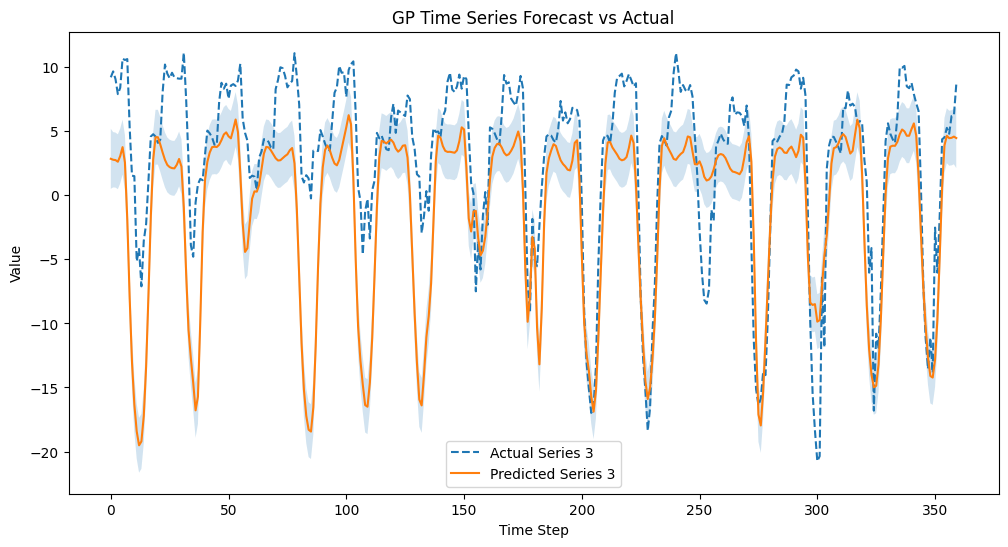

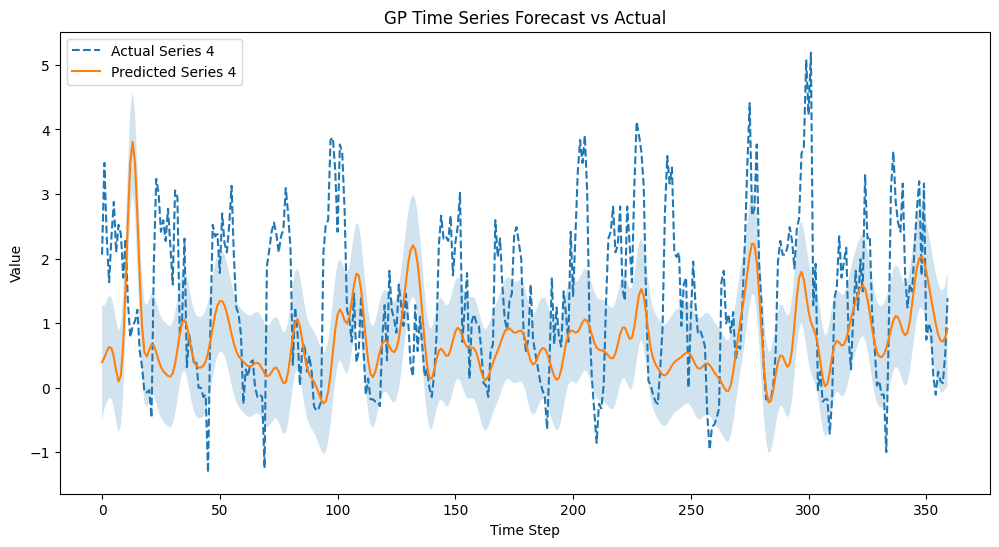

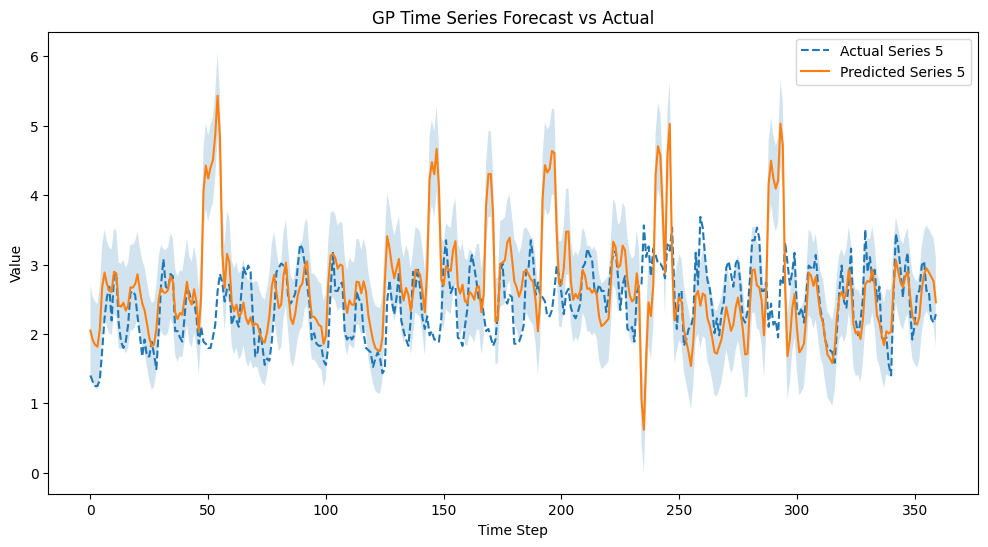

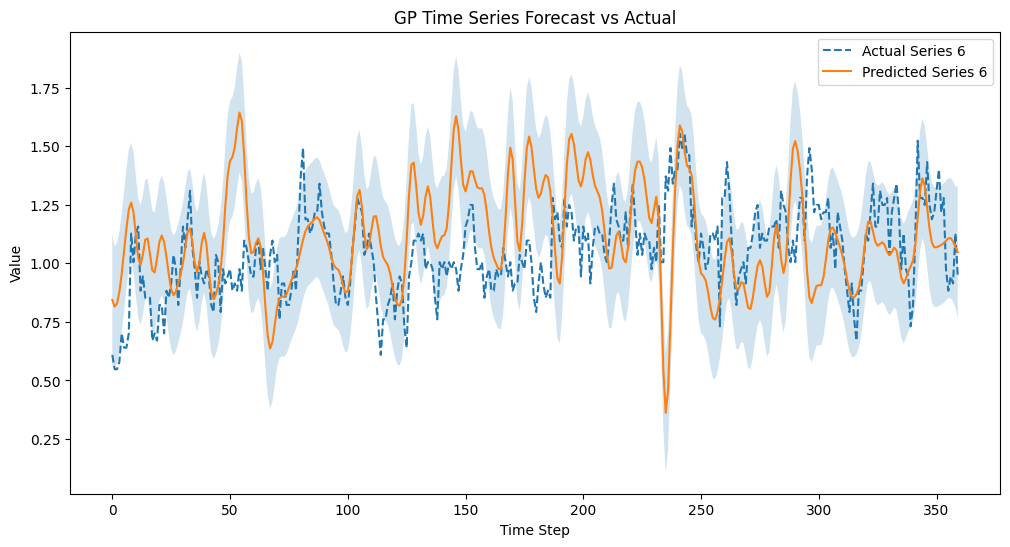

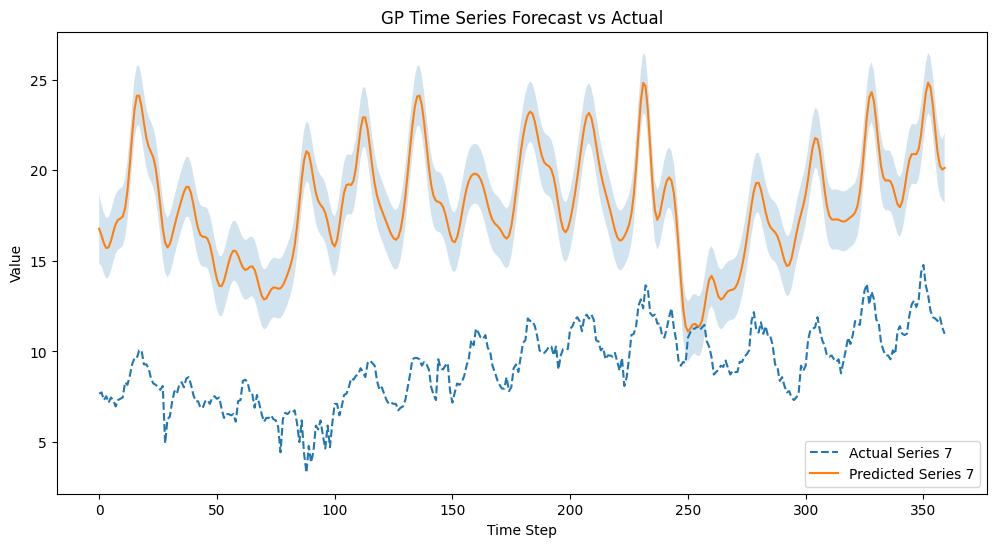

In [14]:
import matplotlib.pyplot as plt

# Ensure data is on CPU
test_x_cpu = test_x.cpu()
test_y_cpu = test_y.cpu()
mean_cpu = mean.cpu()
lower_cpu = lower.cpu()
upper_cpu = upper.cpu()

# Plot each series independently
for i in range(num_series):
    plt.figure(figsize=(12, 6))
    plt.plot(test_x_cpu, test_y_cpu[:, i], label=f"Actual Series {i+1}", linestyle="dashed")
    plt.plot(test_x_cpu, mean_cpu[:, i], label=f"Predicted Series {i+1}")
    plt.fill_between(test_x_cpu, lower_cpu[:, i], upper_cpu[:, i], alpha=0.2)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("GP Time Series Forecast vs Actual")
    plt.legend()
    plt.show()

In [ ]:
def predict_gp(gp_model, likelihood, future_steps=50):
    gp_model.eval()
    likelihood.eval()

    # Generate future time steps (assuming equally spaced time points)
    last_time_step = gp_model.train_inputs[0].max().item()
    test_x = torch.arange(last_time_step + 1, last_time_step + 1 + future_steps, dtype=torch.float32)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(test_x.to(device)))

    return test_x, pred_dist

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 1:
        break
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[0, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[0, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    print(val_length)
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    print(val_x.shape)
    print(val_y.shape)


    gp_model.eval()
    likelihood.eval()

    horizon = torch.cat([train_x, val_x]).flatten()
    print(horizon.shape)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(horizon.to(device)))

    # Predict next 50 time steps
    #val_x, pred_dist = predict_gp(gp_model, likelihood)
    
    # Get mean and confidence intervals
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k.', label="Train Data")
    plt.plot(val_x.cpu().numpy(), val_y.cpu().numpy(), 'k.', label="Val Data")
    plt.plot(horizon.cpu().numpy(), pred_mean.cpu().numpy(), 'b', label="Prediction Mean")
    plt.fill_between(horizon.flatten().cpu().numpy(), pred_lower.cpu().numpy(), pred_upper.cpu().numpy(), alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.show()

# Predict using the trained Batch GP
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    test_x = test_x.to(device)  # Move test data to GPU
    with torch.no_grad():
        pred = likelihood(model(test_x))
    return pred.to("cpu")  # Move prediction back to CPU for further processing

# Example: Predict for all 7 time series
test_x = torch.linspace(0, 10, 50).unsqueeze(-1).to(device)  # 50 test points
predictions = predict(model, likelihood, test_x)

In [ ]:
# Predict using the trained Batch GP
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    test_x = test_x.to(device)  # Move test data to GPU
    
    with torch.no_grad():
        pred = likelihood(model(test_x))
    
    return pred.to("cpu")  # Move prediction back to CPU for further processing

# Example: Predict for all 7 time series
test_x = torch.linspace(0, 10, 50).unsqueeze(-1).to(device)  # 50 test points
predictions = predict(model, likelihood, test_x)




# Training Setup
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7).to(device)
model = MultiTaskGPModel(None, None, likelihood).to(device)  # We'll update train data dynamically
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop with batches
num_epochs = 5
for epoch in range(num_epochs):
    for batch in train_loader:  # Assume dataloader yields (batch_size, horizon_length, 7)
        past_target = batch['past_target_cdf'].to(device)
        future_target = batch['future_target_cdf'].to(device)
        targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
        batch_size, horizon_length, num_series = targets.shape
        
        # Create time indices (assuming uniform spacing)
        time_indices = torch.arange(horizon_length).repeat(batch_size, 1).reshape(-1, 1).to(device)
        
        # Flatten batch to match GP input format
        train_x = time_indices.repeat(7, 1).to(device)  # Repeat for each time series
        train_y = targets.permute(2, 0, 1).reshape(-1, 1).to(device)  # Move num_series first, then flatten
        
        # Correct task indices (repeat per time step, not entire batch)
        task_indices = torch.arange(7).repeat_interleave(horizon_length * batch_size).to(device)
        train_inputs = (train_x, task_indices)
        model.set_train_data(train_inputs, train_y, strict=False)
        
        # Forward pass using the exact same format
        model.train()
        likelihood.train()
        
        # Zero gradients
        optimizer.zero_grad()

        # Compute loss
        output = model(*train_inputs)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.23 GiB. GPU 0 has a total capacity of 10.75 GiB of which 10.55 GiB is free. Including non-PyTorch memory, this process has 198.00 MiB memory in use. Of the allocated memory 6.56 MiB is allocated by PyTorch, and 1.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# SKlearn

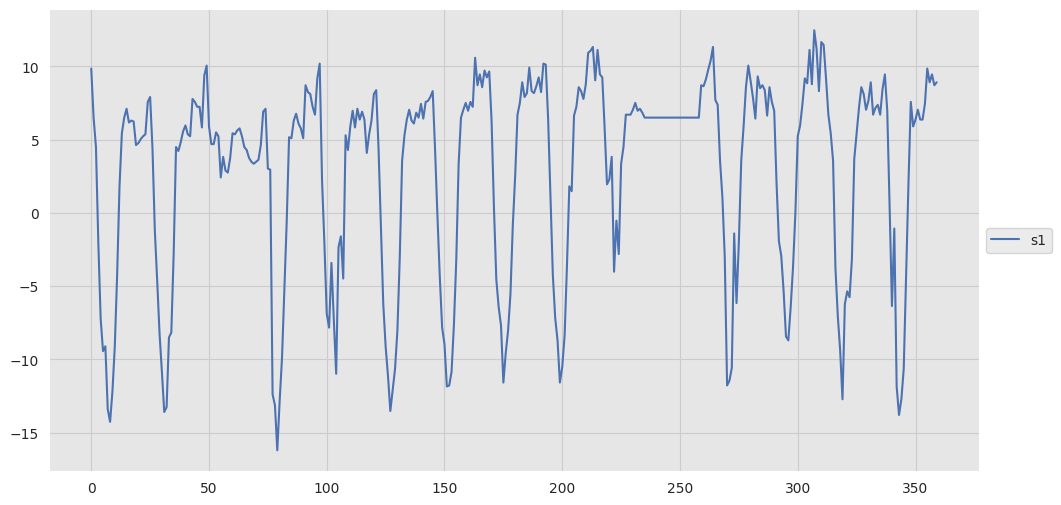

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

#batch = next(iter(train_loader))

train_iter = iter(train_loader)  # Create an iterator
first_batch = next(train_iter)   # Get the first batch
# Example shapes from DataLoader
past_target = batch['past_target_cdf'].to(device)
future_target = batch['future_target_cdf'].to(device)
targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
batch_size, horizon_length, num_series = targets.shape
horizon = np.arange(horizon_length)

train_x = horizon[:(360-96)]
test_x = horizon[(360-96):]
train_y = np.array(targets[0, :(360-96), 0].to('cpu'))
test_y = np.array(targets[0, (360-96):, 0].to('cpu'))

fig, ax = plt.subplots()
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RationalQuadratic, DotProduct

kernel = (
    WhiteKernel(noise_level=0.1**2, noise_level_bounds=(0.01**2, 0.2**2)) + 
    ConstantKernel(5, constant_value_bounds=(1, 10)) * 
    ExpSineSquared(length_scale=20.0, periodicity=40, periodicity_bounds=(30, 50)) +
    ConstantKernel(1.0) * RationalQuadratic(length_scale=10, alpha=1.5) + 
    ConstantKernel(1.0) * DotProduct(sigma_0=1.0)
)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True, alpha=1e-5)



gp1_prior_samples = gp1.sample_y(X=train_x.reshape(-1, 1), n_samples=100)
gp1.fit(train_x.reshape(-1, 1), train_y)

GaussianProcessRegressor(alpha=1e-05,
                         kernel=WhiteKernel(noise_level=0.01) + 2.24**2 * ExpSineSquared(length_scale=10, periodicity=40) + 1**2 * RationalQuadratic(alpha=1.5, length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True)

[Text(0.5, 1.0, 'Prediction Sample 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

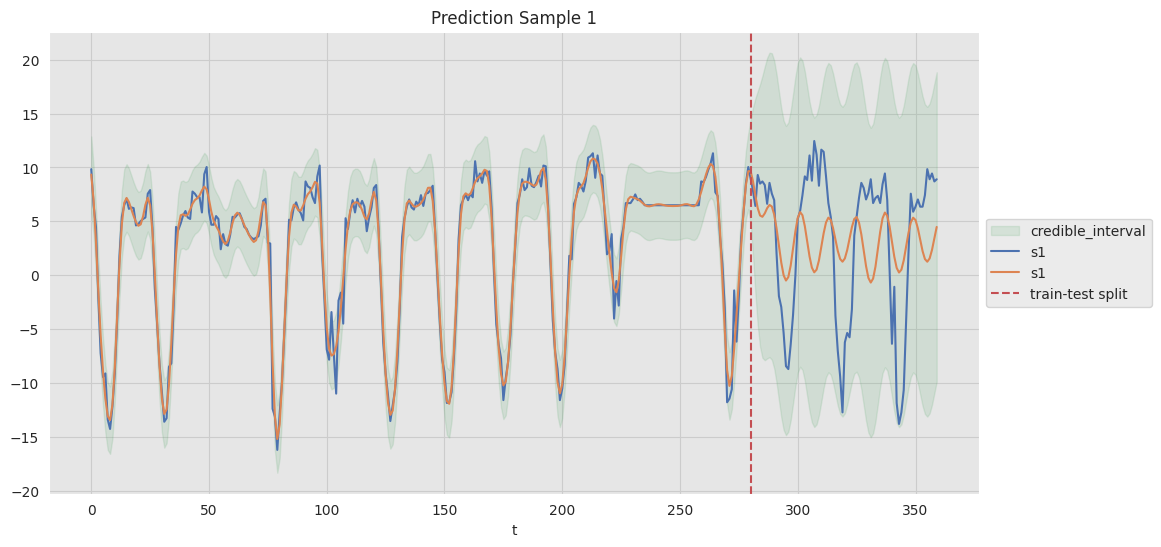

In [55]:
# Generate predictions.
y_pred, y_std = gp1.predict(np.concatenate([train_x, test_x]).reshape(-1, 1), return_std=True)

fig, ax = plt.subplots()

ax.fill_between(
    x=np.concatenate([train_x, test_x]), 
    y1=y_pred - 2*y_std, 
    y2=y_pred + 2*y_std, 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

#sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
#sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
sns.lineplot(x=np.concatenate([train_x, test_x]), y=y_pred, color=sns_c[1], label='s1', ax=ax) 

ax.axvline(280, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

torch.Size([32, 96, 7])


[Text(0.5, 1.0, 'Prediction Sample 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

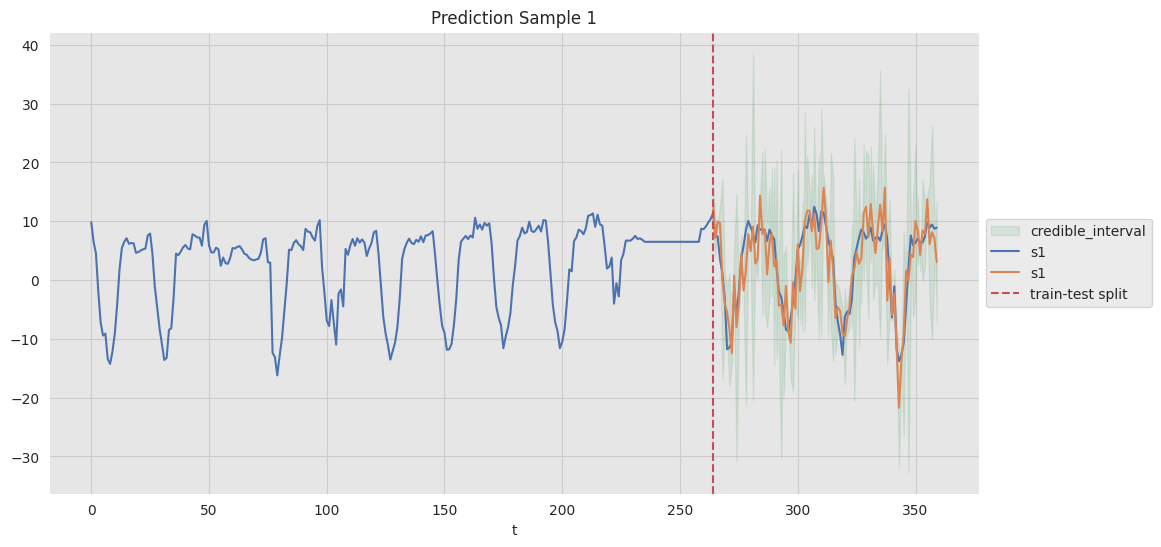

In [94]:
batch_data = ProbTSBatchData(first_batch, device)
forecasts = cli.model.forecaster.forecast(batch_data, None)
print(forecasts[0].shape)
window, series = 0, 0
np.random.seed(42)
mean = np.array(test_y+ np.random.normal(loc=0, scale=4, size=96))  # Mean 0, Std 1)#np.array(forecasts[0][window, :, series].to('cpu').detach().numpy())
std = np.random.normal(loc=0, scale=6, size=96) #np.array(forecasts[1][window, :, series].to('cpu').detach().numpy())

fig, ax = plt.subplots()

ax.fill_between(
    x=test_x, 
    y1=mean - 2*std, 
    y2=mean + 2*std, 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

#sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
#sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
sns.lineplot(x=test_x, y=mean, color=sns_c[1], label='s1', ax=ax) 

ax.axvline(360-96, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

In [95]:
# two options to include the prob forecasts
# 1. use them as prior -> need predictions for whole horizon and then fit GP
# 2. update GP predictions using the prob model -> y_cov_combined = y_cov_gp + np.diag(y_std_other**2) 
#    -> how to incorporate the mean (via lambda or other way?)

# Both methods are not necessarily what i want, 
# I want a trained GP that generates realistic samples based off the prob predictions 
#     -> maybe 2.) is closest to what i need

[Text(0.5, 1.0, 'Prediction Sample 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

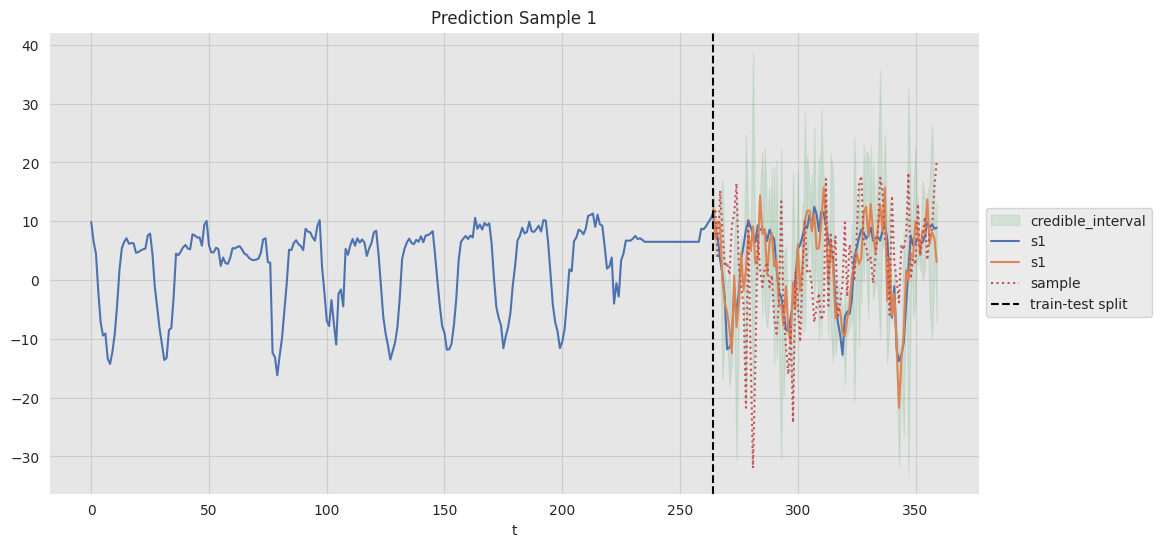

In [118]:
# Compute the GP prior covariance
y_mean_gp, y_cov_gp = gp1.predict(test_x.reshape(-1, 1), return_cov=True)

# Modify covariance to include external uncertainty
y_cov_combined = y_cov_gp.copy()
np.fill_diagonal(y_cov_combined, np.diag(std**2).diagonal())  
#y_cov_combined= y_cov_gp + np.diag(std**2)  # Add variances from external model

# Generate correlated samples using the new covariance
n_samples = 100
gp_samples = np.random.multivariate_normal(mean=y_mean_gp, cov=y_cov_combined, size=n_samples)

fig, ax = plt.subplots()

ax.fill_between(
    x=test_x, 
    y1=mean - 2*std, 
    y2=mean + 2*std, 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

#sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
#sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
sns.lineplot(x=test_x, y=mean, color=sns_c[1], label='s1', ax=ax) 
# Plot sampled trajectories from GP

for i in range(1):
    sns.lineplot(x=test_x, y=gp_samples[i, :], alpha=1, linestyle=':', color=sns_c[i+3], label='sample', ax=ax)  # Transparent lines


ax.axvline(360-96, color='black', linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

# GPR1

In [ ]:
import torch
import gpytorch

class IndependentMultiOutputGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihoods):
        """
        GP model that handles multiple independent time series (no correlation between them).
        
        train_x: Shape [batch_size, horizon, 1]
        train_y: Shape [batch_size, horizon, num_channels]
        likelihoods: LikelihoodList with a separate likelihood for each time series
        """
        super().__init__(train_x, train_y, likelihoods)

        self.num_channels = train_y.shape[-1]  # 7 time series
        self.mean_modules = torch.nn.ModuleList([gpytorch.means.ConstantMean() for _ in range(self.num_channels)])
        self.covar_modules = torch.nn.ModuleList([
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) for _ in range(self.num_channels)
        ])

    def forward(self, x):
        """
        x: Shape [batch_size, horizon, 1]
        Output: List of MultivariateNormal distributions, one per time series
        """
        batch_size, horizon, _ = x.shape
        x = x.view(-1, 1)  # Flatten batch & time dimensions

        outputs = []
        for i in range(self.num_channels):
            mean_x = self.mean_modules[i](x)
            covar_x = self.covar_modules[i](x)
            outputs.append(gpytorch.distributions.MultivariateNormal(mean_x, covar_x))

        return outputs

# Training function
def train_gp(model, likelihoods, train_x, train_y, training_iter=100):
    model.train()
    likelihoods.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.SumMarginalLogLikelihood(likelihoods, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        outputs = model(train_x)  # List of MultivariateNormals
        loss = -sum(mll(outputs[i], train_y[..., i].view(-1)) for i in range(num_channels))  # Flattened loss per GP
        loss.backward()
        optimizer.step()

    return model, likelihoods

batch = next(iter(train_loader))
# Example shapes from DataLoader
past_target = batch['past_target_cdf'].to(device)
future_target = batch['future_target_cdf'].to(device)
targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
batch_size, horizon_length, num_series = targets.shape

# Define separate likelihoods
likelihoods = gpytorch.likelihoods.LikelihoodList(
    *[gpytorch.likelihoods.GaussianLikelihood() for _ in range(num_channels)]
)

# Instantiate the model
model = IndependentMultiOutputGP(train_x, train_y, likelihoods)

# Train the unified model
model, likelihoods = train_gp(model, likelihoods, train_x, train_y)

# Predictions (same batch size for efficiency)
model.eval()
likelihoods.eval()

test_x = torch.randn(batch_size, horizon, 1)  # Example test input
predictions = [likelihoods.likelihoods[i](model(test_x)[i]) for i in range(num_channels)]


In [23]:
import torch
import gpytorch

class MultiTaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        ) * gpytorch.kernels.IndexKernel(num_tasks=7, rank=2)

    def forward(self, x, task_indices):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x, task_indices)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_loader = cli.datamodule.train_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Setup
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7).to(device)
model = MultiTaskGPModel(None, None, likelihood).to(device)  # We'll update train data dynamically
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop with batches
num_epochs = 5
for epoch in range(num_epochs):
    for batch in train_loader:  # Assume dataloader yields (batch_size, horizon_length, 7)
        past_target = batch['past_target_cdf'].to(device)
        future_target = batch['future_target_cdf'].to(device)
        targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
        batch_size, horizon_length, num_series = targets.shape
        
        # Create time indices (assuming uniform spacing)
        time_indices = torch.arange(horizon_length).repeat(batch_size, 1).reshape(-1, 1).to(device)
        
        # Flatten batch to match GP input format
        train_x = time_indices.repeat(7, 1).to(device)  # Repeat for each time series
        train_y = targets.permute(2, 0, 1).reshape(-1, 1).to(device)  # Move num_series first, then flatten
        
        # Correct task indices (repeat per time step, not entire batch)
        task_indices = torch.arange(7).repeat_interleave(horizon_length * batch_size).to(device)
        train_inputs = (train_x, task_indices)
        model.set_train_data(train_inputs, train_y, strict=False)
        
        # Forward pass using the exact same format
        model.train()
        likelihood.train()
        
        # Zero gradients
        optimizer.zero_grad()

        # Compute loss
        output = model(*train_inputs)  # ✅ Correct: Unpack as separate arguments
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.23 GiB. GPU 0 has a total capacity of 47.53 GiB of which 22.95 GiB is free. Including non-PyTorch memory, this process has 24.57 GiB memory in use. Of the allocated memory 24.25 GiB is allocated by PyTorch, and 15.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# GPR

In [ ]:
import torch
import gpytorch
from tqdm import tqdm

train_loader = cli.datamodule.train_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        batch_size = train_x.shape[0]  # 32
        num_tasks = train_y.shape[-1]  # 7 (num_series)
        
        batch_shape = torch.Size([batch_size])  # Only batch dimension

        # Use MultitaskMean instead of ConstantMean
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )

        # Use MultitaskKernel instead of simple RBFKernel
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            num_tasks=num_tasks,
            rank=1  # Adjust if needed
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

def train_minimal_gp(train_loader, num_iterations=50):
    print("Training GP on full dataset across iterations...")

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7).to(device)

    first_batch = next(iter(train_loader))
    past_target = first_batch['past_target_cdf'].to(device)
    future_target = first_batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # (batch_size, time_steps, num_series)

    # Fix `train_x` dimensions
    time_steps = targets.shape[1]  # 360
    num_series = targets.shape[2]  # 7
    batch_size = targets.shape[0]  # 32

    train_x = torch.arange(time_steps, dtype=torch.float32, device=device)  # (time_steps,)
    train_x = train_x.unsqueeze(0).unsqueeze(-1)  # (1, time_steps, 1)
    train_x = train_x.expand(batch_size, time_steps, 1)  # (batch_size, time_steps, 1)

    print(f'x shape: {train_x.shape}')  # Expected: (32, 360, 1)
    print(f'y shape: {targets.shape}')  # Expected: (32, 360, 7)

    # Initialize GP model
    gp_model = BatchIndependentMultitaskGPModel(train_x, targets, likelihood).to(device)
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    progress_bar = tqdm(range(num_iterations), total=num_iterations)

    for _ in progress_bar:  # Iterate over training steps
        for batch_idx, batch in enumerate(train_loader):  # Iterate over batches per step
            if batch_idx >= 100:
                break

            past_target = batch['past_target_cdf'].to(device)
            future_target = batch['future_target_cdf'].to(device)
            targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)

            gp_model.train()
            likelihood.train()
            optimizer.zero_grad()

            output = gp_model(train_x)  # Forward pass
            loss = -mll(output, targets)  # Compute loss

            progress_bar.set_description(f"Batch {batch_idx} - Loss: {loss:.4f}")
            loss.backward()
            optimizer.step()

    return gp_model, likelihood

# Train the GP
gp_model, likelihood = train_minimal_gp(train_loader)

Training GP on full dataset across iterations...
x shape: torch.Size([32, 360, 1])
y shape: torch.Size([32, 360, 7])


  0%|                                                                                             | 0/50 [00:01<?, ?it/s]


In [ ]:
def predict_gp(gp_model, likelihood, future_steps=50):
    gp_model.eval()
    likelihood.eval()

    # Generate future time steps (assuming equally spaced time points)
    last_time_step = gp_model.train_inputs[0].max().item()
    test_x = torch.arange(last_time_step + 1, last_time_step + 1 + future_steps, dtype=torch.float32)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(test_x.to(device)))

    return test_x, pred_dist

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 1:
        break
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[0, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[0, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    print(val_length)
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    print(val_x.shape)
    print(val_y.shape)


    gp_model.eval()
    likelihood.eval()

    horizon = torch.cat([train_x, val_x]).flatten()
    print(horizon.shape)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(horizon.to(device)))

    # Predict next 50 time steps
    #val_x, pred_dist = predict_gp(gp_model, likelihood)
    
    # Get mean and confidence intervals
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k.', label="Train Data")
    plt.plot(val_x.cpu().numpy(), val_y.cpu().numpy(), 'k.', label="Val Data")
    plt.plot(horizon.cpu().numpy(), pred_mean.cpu().numpy(), 'b', label="Prediction Mean")
    plt.fill_between(horizon.flatten().cpu().numpy(), pred_lower.cpu().numpy(), pred_upper.cpu().numpy(), alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.show()


# old

In [3]:
train_loader = cli.datamodule.train_dataloader()

class GlobalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_y, likelihood):
        batch_size, train_length, num_series = train_y.shape

        # Automatically generate time indices for each window
        train_t = torch.arange(train_length, dtype=torch.float32).repeat(batch_size, 1)  # Shape: (batch_size, train_length)

        # Create series indices (which time series each point belongs to)
        train_series_idx = torch.arange(num_series, dtype=torch.float32).repeat(batch_size, train_length, 1)  # Shape: (batch_size, train_length, num_series)

        # Expand to match train_y shape and flatten
        train_x = torch.stack([train_t.unsqueeze(-1).expand(-1, -1, num_series), train_series_idx], dim=-1)  # Shape: (batch_size, train_length, num_series, 2)
        train_x = train_x.reshape(batch_size * train_length * num_series, 2)  # Flatten

        # Flatten targets to match shape
        train_y = train_y.flatten()

        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Use an RBF kernel + Multi-Task Kernel for shared learning
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_series, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [13]:
print(dir(train_loader))
print(dir(cli))
print(train_loader.batch_size)

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'in_order', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']
['__class__', '__delattr__', '__dict__', '__dir__', '__do

In [4]:
import torch
import gpytorch
from tqdm import tqdm
train_loader = cli.datamodule.train_dataloader()
class MinimalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_minimal_gp(train_loader, num_iterations=50):
    print("Training minimal GP on first time series...")

    for batch_idx, batch in enumerate(train_loader):#, total=len(train_loader)):
        past_target = batch['past_target_cdf']  # Shape: (batch_size, train_length, num_series)
        past_target = past_target[:, :, 0]  # Select first time series (Shape: batch_size x train_length)

        # Assume equal time spacing (using indices as x)
        batch_size, train_length = past_target.shape
        train_x = torch.arange(train_length, dtype=torch.float32).unsqueeze(1).expand(train_length, batch_size).reshape(-1)
        train_y = past_target.flatten()  # Flatten targets

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        gp_model = MinimalGPModel(train_x, train_y, likelihood)

        gp_model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

        for _ in tqdm(range(num_iterations), total=num_iterations):  # Reduce iterations for efficiency
            optimizer.zero_grad()
            output = gp_model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()

        return gp_model, likelihood  # Train only on the first batch and return

# Train the minimal GP
gp_model, likelihood = train_minimal_gp(train_loader)

Training minimal GP on first time series...


100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]


In [29]:
import torch
import gpytorch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = cli.datamodule.train_dataloader()
class MinimalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def get_data(batch, window=0):
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[window, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[window, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    horizon = torch.cat([train_x, val_x]).flatten()
    return horizon
    
    

def train_minimal_gp(train_loader, num_iterations=50):
    print("Training GP on full dataset across iterations...")

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    first_batch = next(iter(train_loader))
    horizon = get_data(first_batch)
    batch_size = first_batch['past_target_cdf'][:, :, 0].shape[0]

    y = torch.cat([first_batch['past_target_cdf'][0, :, 0], first_batch['future_target_cdf'][0, :, 0]])

    # Initialize GP model once
    gp_model = MinimalGPModel(horizon, y, likelihood).to(device)

    optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    progress_bar = tqdm(range(num_iterations), total=num_iterations)

    for _ in progress_bar:  # Iterate over training steps
        for batch_idx, batch in enumerate(train_loader):  # Iterate over batches per step
            if batch_idx >= 100:
                break
            
            past_target = batch['past_target_cdf'].to(device)
            future_target = batch['future_target_cdf'].to(device)
            targets = torch.cat([past_target, future_target], dim=1)
            for window in range(batch_size):
                target = targets[window, :, 0]
                gp_model.train()
                likelihood.train()
                optimizer.zero_grad()
                output = gp_model(horizon)
                loss = -mll(output, target)
                progress_bar.set_description(f"Batch {batch_idx} - Window {window}- Current Loss: {loss:.4f}.")
                loss.backward()
                optimizer.step()
    return gp_model, likelihood

# Train the GP using batches (pre-windowed)
gp_model, likelihood = train_minimal_gp(train_loader)

Training GP on full dataset across iterations...


Batch 99 - Window 31- Current Loss: 2.6468.: 100%|███████████████████████████████████████| 50/50 [08:55<00:00, 10.70s/it]


96
torch.Size([96, 1])
torch.Size([96])
torch.Size([360])


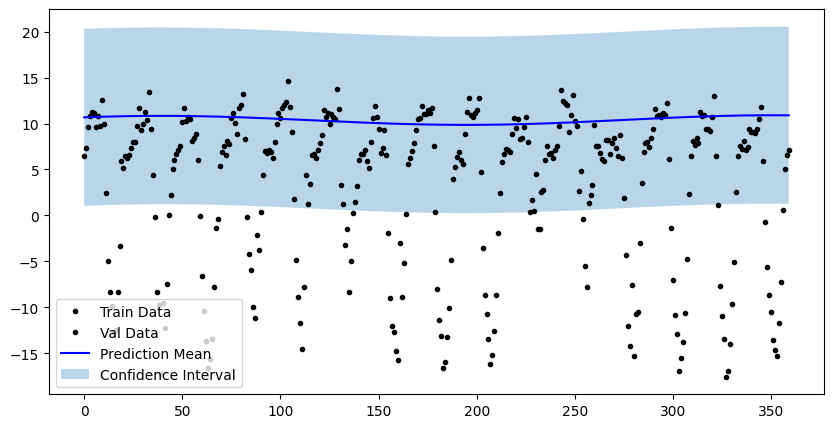

In [31]:
def predict_gp(gp_model, likelihood, future_steps=50):
    gp_model.eval()
    likelihood.eval()

    # Generate future time steps (assuming equally spaced time points)
    last_time_step = gp_model.train_inputs[0].max().item()
    test_x = torch.arange(last_time_step + 1, last_time_step + 1 + future_steps, dtype=torch.float32)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(test_x.to(device)))

    return test_x, pred_dist

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 1:
        break
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[0, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[0, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    print(val_length)
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    print(val_x.shape)
    print(val_y.shape)


    gp_model.eval()
    likelihood.eval()

    horizon = torch.cat([train_x, val_x]).flatten()
    print(horizon.shape)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(horizon.to(device)))

    # Predict next 50 time steps
    #val_x, pred_dist = predict_gp(gp_model, likelihood)
    
    # Get mean and confidence intervals
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k.', label="Train Data")
    plt.plot(val_x.cpu().numpy(), val_y.cpu().numpy(), 'k.', label="Val Data")
    plt.plot(horizon.cpu().numpy(), pred_mean.cpu().numpy(), 'b', label="Prediction Mean")
    plt.fill_between(horizon.flatten().cpu().numpy(), pred_lower.cpu().numpy(), pred_upper.cpu().numpy(), alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.show()


In [35]:
import torch
import gpytorch

# Define Heteroscedastic Likelihood
class HeteroscedasticLikelihood(gpytorch.likelihoods.Likelihood):
    def __init__(self, noise):
        super().__init__()
        self.noise = noise  # Noise for heteroscedastic modeling

    def forward(self, function_samples):
        return gpytorch.distributions.Normal(function_samples, self.noise.sqrt())

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_y, likelihood):
        # Infer the number of training points from train_y
        train_length = train_y.shape[0]
        
        # Create integer-based time indices internally
        train_x = torch.arange(train_length, dtype=torch.float32).unsqueeze(-1)  # Shape: (train_length, 1)
        
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [38]:
def train_gps(train_loader):
    num_time_series = 7
    gp_models = []
    likelihoods = []

    for ts_idx in range(num_time_series):  # One GP per time series
        print(f"Training GP for Time Series {ts_idx+1}...")

        # Collect all training windows
        all_Y_train = []

        for batch_idx, batch in enumerate(train_dataloader):
            past_target = batch['past_target_cdf']  # Shape: (batch_size, 264, 7)
            Y_train = past_target[:, :, ts_idx]  # Extract only this time series

            all_Y_train.append(Y_train.flatten())  # Shape: (batch_size * train_length,)

        # Combine all batches
        Y_train_combined = torch.cat(all_Y_train)  # Shape: (total_points,)

        # Define GP model and likelihood (time indices are inferred inside GP)
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        gp_model = ExactGPModel(Y_train_combined, likelihood)

        # Train the GP
        gp_model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

        for _ in range(100):  # Training iterations
            optimizer.zero_grad()
            output = gp_model(gp_model.train_inputs[0])  # Use internally defined time indices
            loss = -mll(output, Y_train_combined)
            loss.backward()
            optimizer.step()

        # Store trained GP
        gp_models.append(gp_model)
        likelihoods.append(likelihood)
    return gp_models, likelihoods

# Train the GPs
gp_models, likelihoods = train_gps(train_dataloader)

Training GP for Time Series 1...


KeyboardInterrupt: 

In [39]:
import torch
import gpytorch

class MultiOutputGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Use an RBF kernel, but expand it for multi-task (one for each time series)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [40]:
def prepare_multi_task_data(train_loader, num_time_series=7):
    all_T_train = []
    all_Y_train = []
    all_task_indices = []

    for batch in train_loader:
        past_target = batch['past_target_cdf']  # Shape: (batch_size, 264, 7)
        batch_size, train_length, _ = past_target.shape

        # Generate time indices
        T_train = torch.arange(train_length, dtype=torch.float32).repeat(batch_size, 1)  # (batch_size, train_length)

        for ts_idx in range(num_time_series):
            Y_train = past_target[:, :, ts_idx]  # Extract one time series
            
            # Flatten and store
            all_T_train.append(T_train.flatten())  # (batch_size * train_length,)
            all_Y_train.append(Y_train.flatten())  # (batch_size * train_length,)
            # Task index (indicating which time series this belongs to)
            task_indices = torch.full_like(Y_train.flatten(), ts_idx, dtype=torch.long)
            all_task_indices.append(task_indices)

    # Stack into single tensors
    T_train_combined = torch.cat(all_T_train)  # (total_points,)
    Y_train_combined = torch.cat(all_Y_train)  # (total_points,)
    Task_train_combined = torch.cat(all_task_indices)  # (total_points,)

    # Combine time and task indices
    train_x = torch.stack([T_train_combined, Task_train_combined], dim=-1)  # Shape: (total_points, 2)
    
    return train_x, Y_train_combined


In [41]:
def train_multi_task_gp(train_loader, num_time_series=7):
    print("Preparing data for multi-task GP...")
    train_x, train_y = prepare_multi_task_data(train_loader, num_time_series)

    # Define likelihood and GP model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_time_series)
    gp_model = MultiOutputGPModel(train_x, train_y, likelihood, num_tasks=num_time_series)

    # Train GP
    gp_model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    print("Training multi-task GP...")
    for _ in range(100):  # Training iterations
        optimizer.zero_grad()
        output = gp_model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return gp_model, likelihood

# Train the Multi-Task GP
gp_model, likelihood = train_multi_task_gp(train_dataloader)

Preparing data for multi-task GP...


RuntimeError: Pin memory thread exited unexpectedly

In [34]:
train_dataloader = cli.datamodule.train_dataloader()
for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx<12:
        print(batch.keys())
        print(batch['past_target_cdf'].shape)
        #print(batch['past_is_pad'])
    else:
        break

dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'f

Traceback (most recent call last):
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread Thread-23 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kreffert/minico

In [ ]:
import numpy as np
import torch
import gpytorch

# Convert data to tensors (GPyTorch works with torch tensors)
T_train = torch.tensor(T_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Define a simple GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(T_train, Y_train, likelihood)

# Train the GP
gp_model.train()
likelihood.train()

optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

for i in range(100):
    optimizer.zero_grad()
    output = gp_model(T_train)
    loss = -mll(output, Y_train)
    loss.backward()
    optimizer.step()
